In [1]:

import sys
sys.path.append('../Scripts')
from PostProcessingScripts import * 


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
colors = ['#1f77b4', '#ff7f0e']
colors_lighter = [adjust_lightness(color=colors[0], amount=2.2),adjust_lightness(color=colors[1], amount=1.7)]


import random


obtain index of the SFRD models that we want to highlight


In [2]:
markershapes = ["*", "o", "v",  "p", "H", "^", ">", 'X', "+","<", 'x', "3","d","1", "|", "D", "P", "X", "+", "d"]
dictMarkerShape = {BPSnameslist[i]: markershapes[i] for i in range(len(BPSnameslist))}

In [3]:
def GW_credible_intervals(GW_name, mode):

    # GW_list = ['GW151226','GW170729', 'GW190517_055101', 'GW190412','GW191109_010717'  ,'GW191103_012549', 'GW191126_115259']

    
    dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
    dfCSVname_ = dfCSVname + 'posteriorSamples_' + GW_name  + '.csv' 


    df = pd.read_csv(dfCSVname_, index_col=0, skiprows=[1])
    mass_ratio = df['M2']/df['M1']
    total_mass = df['M2'] + df['M1']
    spin1 = df['spin1'] 
    spin2 = df['spin2'] 
    
    chi_eff = df['chi_eff']
    chirp_mass = chirpmass(df['M2'], df['M1'])
    y_quantiles = [0.05, 0.5, 0.95]

    if mode=='normal':
    
        total_mass_CI = weighted_quantile(values=total_mass, quantiles=y_quantiles)
        mass1_CI = weighted_quantile(values=df['M1'], quantiles=y_quantiles)
        mass2_CI = weighted_quantile(values=df['M2'], quantiles=y_quantiles)
        chirp_mass_CI = weighted_quantile(values=chirp_mass, quantiles=y_quantiles)
        mass_ratio_CI = weighted_quantile(values=mass_ratio, quantiles=y_quantiles)
        spin1_CI = weighted_quantile(values=spin1, quantiles=y_quantiles)    
        spin2_CI = weighted_quantile(values=spin2, quantiles=y_quantiles)    
        chi_eff_quantiles = weighted_quantile(values=chi_eff, quantiles=y_quantiles)    

    elif mode=='spin1_is_zero':
        mask_spin = (abs(spin1)<0.05) & (spin2>0.05) # non MRR, spin 2 is the spinning one, we want spin1 to be zero 
        total_mass_CI = weighted_quantile(values=total_mass[mask_spin], quantiles=y_quantiles)
        mass1_CI = weighted_quantile(values=df['M1'][mask_spin], quantiles=y_quantiles)
        mass2_CI = weighted_quantile(values=df['M2'][mask_spin], quantiles=y_quantiles)
        chirp_mass_CI = weighted_quantile(values=chirp_mass[mask_spin], quantiles=y_quantiles)
        mass_ratio_CI = weighted_quantile(values=mass_ratio[mask_spin], quantiles=y_quantiles)
        spin1_CI = weighted_quantile(values=spin1[mask_spin], quantiles=y_quantiles)    
        spin2_CI = weighted_quantile(values=spin2[mask_spin], quantiles=y_quantiles)    
        chi_eff_quantiles = weighted_quantile(values=chi_eff[mask_spin], quantiles=y_quantiles)   

    elif  mode=='spin2_is_zero':
        mask_spin = (abs(spin2)<0.05) & (spin1>0.05) #  # MRR spin1 is the spinning one, we want the other one to be zero
        total_mass_CI = weighted_quantile(values=total_mass[mask_spin], quantiles=y_quantiles)
        mass1_CI = weighted_quantile(values=df['M1'][mask_spin], quantiles=y_quantiles)
        mass2_CI = weighted_quantile(values=df['M2'][mask_spin], quantiles=y_quantiles)
        chirp_mass_CI = weighted_quantile(values=chirp_mass[mask_spin], quantiles=y_quantiles)
        mass_ratio_CI = weighted_quantile(values=mass_ratio[mask_spin], quantiles=y_quantiles)
        spin1_CI = weighted_quantile(values=spin1[mask_spin], quantiles=y_quantiles)    
        spin2_CI = weighted_quantile(values=spin2[mask_spin], quantiles=y_quantiles)    
        chi_eff_quantiles = weighted_quantile(values=chi_eff[mask_spin], quantiles=y_quantiles)   

    return total_mass_CI, mass1_CI, mass2_CI, chirp_mass_CI, mass_ratio_CI, spin1_CI, spin2_CI, chi_eff_quantiles
    


# Figure 10 

In [4]:
def plot_3Msun_lines(axes, xlim=[1,100]):
    # m2 = 3 Msun 
    q=np.linspace(0.001, 1, 100)
    m2 = 2 # Msun 
    mtot = (1+(1/q))*m2
    axes.plot(mtot, q, c='gray', lw=2, linestyle=':', zorder=1E4)
    axes.text(mtot[2], q[3], s=r'$m_2 = 2 \, \rm{M}_{\odot}$', fontsize=fs-6, rotation=-3)
    

    return


def make_up_axes(axes=None, xlim=[2,400], ylim=[0,1], xlabel=None, ylabel=None, logX=True,  logY=False):
    
    
    if (xlabel!=None) & (ylabel!=None):
        layoutAxes(ax=axes, nameX=xlabel, nameY=ylabel, labelpad=20)
    elif xlabel==None:
        layoutAxesNoXlabel(ax=axes, nameX=xlabel, nameY=ylabel, labelpad=20)
    elif ylabel==None:
        layoutAxesNoYlabel(ax=axes, nameX=xlabel, nameY=ylabel, labelpad=20)    

    
    if logX!=False:
        axes.set_xscale('log')     
    if logY!=False:
        axes.set_yscale('log')       
    return 




def plot_x_ticks(axe=None, xtick_loc=[1, 2, 4, 7, 10, 20, 40, 70, 100, 200, 400], ytick_loc=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], xlim=[2,400], ylim=[0,1],tick_fs=20):
    

    fs = 18
    xtick_name = []
    for ind, xtick in enumerate(xtick_loc):
        xtick_name.append(r'${%s}$'%str(xtick))
        axe.plot(np.ones(100)*xtick, np.linspace(ylim[0], ylim[1], 100), c='lightgray', lw=1.2, linestyle='-', zorder=0)
    
    axe.set_xticks(xtick_loc)
    axe.set_xticklabels(xtick_name, fontsize=tick_fs, rotation=0)#, orientation=30) 
    
    
    ytick_name = []
    for ind, ytick in enumerate(ytick_loc):
        ytick_name.append(r'${%s}$'%str(ytick))
        axe.plot(np.linspace(xlim[0], xlim[1], 100), np.ones(100)*ytick, c='lightgray', lw=1.2, linestyle='-', zorder=0)
    
    axe.set_yticks(ytick_loc)
    axe.set_yticklabels(ytick_name, fontsize=tick_fs, rotation=0)#, orientation=30)  
    
    axe.set_xlim(xlim[0], xlim[1])
    axe.set_ylim(ylim[0], ylim[1])

    return 



def plot_GW_contours_all(axe, xparam, GW_highlight):

    for ind, GW_name in enumerate(GW_highlight):
        print(GW_name)
        
        dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
        dfCSVname_ = dfCSVname + 'posteriorSamples_' + GW_name  + '.csv' 


        df = pd.read_csv(dfCSVname_, index_col=0, skiprows=[1])
        mass_ratio = df['M2']/df['M1']
        total_mass = df['M2'] + df['M1']
        spin1 = df['spin1'] 
        spin2 = df['spin2'] 
        
        chi_eff = df['chi_eff']
        chirp_mass = chirpmass(df['M2'], df['M1'])
        
  
        c_highlight= 'k'
        c_highlight_nonMRR = 'k'
        c_gray = 'lightgray'


        zorder = 115
        color=c_highlight

        print(GW_name, ' total mass = ', np.median(total_mass) )
        print(GW_name, ' chirp mass = ', np.median(chirp_mass) )
        if xparam=='Mtot_vs_q':
             sns.kdeplot(x=total_mass, y=mass_ratio, levels=[0.1], zorder=zorder, color=color,ax=axe) 
                
        elif xparam=='ChirpMass_vs_ChiEff':
            sns.kdeplot(x=chirp_mass, y=chi_eff, levels=[0.1], zorder=zorder, color=color,ax=axe) 

        elif xparam=='ChiEff_vs_q':                
            sns.kdeplot(x=chi_eff, y=mass_ratio, levels=[0.1], zorder=zorder, color=color,ax=axe) 

            
            
            
            
def plot_GW_contours(axe, xparam, which):

    GW_list = ['GW151226','GW170729', 'GW190517_055101', 'GW190412'] #,'GW191109_010717'  ,'GW191103_012549', 'GW191126_115259']


    for ind, GW_name in enumerate(GW_list):
        print(GW_name)
        
        dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
        dfCSVname_ = dfCSVname + 'posteriorSamples_' + GW_name  + '.csv' 


        df = pd.read_csv(dfCSVname_, index_col=0, skiprows=[1])
        mass_ratio = df['M2']/df['M1']
        total_mass = df['M2'] + df['M1']
        spin1 = df['spin1'] 
        spin2 = df['spin2'] 
        
        chi_eff = df['chi_eff']
        chirp_mass = chirpmass(df['M2'], df['M1'])
        
  
        

        if xparam=='Mtot_vs_q':
            sns.kdeplot(x=total_mass, y=mass_ratio, levels=[0.1], zorder=11, color='k',ax=axe)
            mask_spin2 = (abs(spin2)<0.05) & (spin1>0.05) # MRR spin1 is the spinning one, we want the other one to be zero
            mask_spin1 = (abs(spin1)<0.05) & (spin2>0.05)# non MRR, spin 2 is the spinning one, we want spin1 to be zero  
            if which== 'allMRR':
                sns.kdeplot(x=total_mass[mask_spin2], y=mass_ratio[mask_spin2], kde_kws=dict(linestyle=':', linewidth=5), levels=[0.1], zorder=12, color=colors[1],ax=axe)
            elif which== 'allNonMRR':    
                sns.kdeplot(x=total_mass[mask_spin1], y=mass_ratio[mask_spin1], levels=[0.1], zorder=12, color=colors[0], kde_kws=dict(linestyle=':', linewidth=3),ax=axe)

                
        elif xparam=='ChirpMass_vs_ChiEff':
            sns.kdeplot(x=chirp_mass, y=chi_eff, levels=[0.1], zorder=11, color='k', ax=axe)
            mask_spin2 = abs(spin2)<0.05 # MRR spin1 is the spinning one, we want the other one to be zero
            mask_spin1 = abs(spin1)<0.05 # non MRR, spin 2 is the spinning one, we want spin1 to be zero 
            if which== 'allMRR':
                sns.kdeplot(x=chirp_mass[mask_spin2], y=chi_eff[mask_spin2], kde_kws=dict(linestyle=':', linewidth=5), levels=[0.1], zorder=12, color=colors[1],ax=axe)
            elif which== 'allNonMRR':     
                sns.kdeplot(x=chirp_mass[mask_spin1], y=chi_eff[mask_spin1], levels=[0.1], zorder=12, color=colors[0], kde_kws=dict(linestyle=':', linewidth=3),ax=axe)
          
        
        elif xparam=='ChiEff_vs_q':
            sns.kdeplot(x=chi_eff, y=mass_ratio, levels=[0.1], zorder=11, color='k', ax=axe)

            mask_spin2 = (abs(spin2)<0.05) & (spin1>0.05) # MRR spin1 is the spinning one, we want the other one to be zero
            mask_spin1 = (abs(spin1)<0.05) & (spin2>0.05)# non MRR, spin 2 is the spinning one, we want spin1 to be zero  
            if which== 'allMRR':
                sns.kdeplot(x=chi_eff[mask_spin2], y=mass_ratio[mask_spin2], kde_kws=dict(linestyle=':', linewidth=5), levels=[0.1], zorder=12, color=colors[1],ax=axe)
            elif which== 'allNonMRR':     
                sns.kdeplot(x=chi_eff[mask_spin1], y=mass_ratio[mask_spin1], levels=[0.1], zorder=12, color=colors[0], kde_kws=dict(linestyle=':', linewidth=3),ax=axe)
            
            



def plot_Fig_GWTC(axe, xparam='chiEff', BPSmodelName='A', mssfr='112', which='allMRR'):
    
    labellist= np.ones(5) #,  r'$\log_{10}(t) $']      

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path, 'r')
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    seedsDCO  = fdata['doubleCompactObjects']['seed'][...].squeeze()  # get the seeds in the DCO file 
    seedsSN   = fdata['supernovae']['randomSeed'][...].squeeze()    # get the seeds in the SN file 
    indices   = np.sort(np.unique(seedsSN[1::2], return_index=True)[1])
    maskSNdco = np.in1d(seedsSN,  seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
    whichSN   = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]  # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova     
    whichSN2  = whichSN[1::2][indices]

    # either SN2 = primary (1) and M1 is > M2, or SN2 = secondary & M1 < M2 
    # this takes into account (first term) rejuvenation 
    mask_MRR = ((whichSN2==1) & (massCO_ZAMSM1>massCO_ZAMSM2) ) | ((whichSN2==2) & (massCO_ZAMSM1<massCO_ZAMSM2)) 

    
    tc= fdata['doubleCompactObjects']['tc'][...].squeeze()
    tform= fdata['doubleCompactObjects']['tform'][...].squeeze()
    
    del whichSN2
    del whichSN
    del maskSNdco
    del indices
    del seedsSN
    del seedsDCO

    spin = COspin(data_path=path, state='he_depletion')  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 

    spinLVKM1, spinLVKM2 = np.zeros_like(spinZAMSM1), np.zeros_like(spinZAMSM1)
    spinLVKM1[mask_MRR] = spinZAMSM2[mask_MRR]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
    spinLVKM1[~mask_MRR] = spinZAMSM1[~mask_MRR]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
    spinLVKM2[mask_MRR] = spinZAMSM1[mask_MRR]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
    spinLVKM2[~mask_MRR] = spinZAMSM2[~mask_MRR]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     

    # spin_threshold = 0.05 # definition of "spinning BH"
    mask_LVKM1_spinning = (spinLVKM1 > spin_threshold ) # more massive = spinning: MRR 
    mask_LVKM2_spinning = (spinLVKM2 > spin_threshold ) # less nassuve BH = spinning (Non MRR)
    mask_anySpin = (spinLVKM1 > spin_threshold ) | (spinLVKM2 > spin_threshold )        

    M1LVK, M2LVK = massCO_LVKM1, massCO_LVKM2 
    chi_eff = ((spinLVKM1*M1LVK) + (spinLVKM2*M2LVK)) / (M1LVK + M2LVK)
    chirp_mass = chirpmass(M1LVK, M2LVK)
    mass_ratio_LVK =  M2LVK/M1LVK
    MRR_mask = mask_MRR

    if xparam=='ChirpMass_vs_ChiEff':
        chi_eff = ((spinZAMSM1 *massCO_ZAMSM1) + spinZAMSM2*massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2) 
        param_y = chi_eff
    elif xparam=='Mtot_vs_q':
        param_x = massCO_ZAMSM1 + massCO_ZAMSM2
        param_y = MassRatioCO_LVK        
    elif xparam=='ChiEff_vs_q':
        chi_eff = ((spinZAMSM1 *massCO_ZAMSM1) + spinZAMSM2*massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
        param_x = chi_eff 
        param_y = massCO_LVKM2 / massCO_LVKM1
        
        
    elif xparam=='ChiEff_vs_tdelay': 
        chi_eff = ((spinZAMSM1 *massCO_ZAMSM1) + spinZAMSM2*massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
        param_x = chi_eff 
        param_y = tc / 1000. # in Gyr

        
        
    NN_ = 1000
    size_ = 1
    size_big = 50
    Ndraw_temp = 100
    zorder=9  
    
    if (which=='allMRR') | (which=='allSpin1'):
        color_BPS =colors_lighter[1]
        color_scatter = colors[1]
    elif (which=='allNonMRR') | (which=='allSpin2'):
        color_BPS = colors_lighter[0]
        color_scatter = colors[0]
    elif which in ['perModelMRR', 'perModelNonMRR']:
        color_BPS = [adjust_lightness(color= colorDirDict[BPSmodelName], amount=1.3)]
        color_scatter = [colorDirDict[BPSmodelName]]
        size_big = 100
    

    if (which in  ['allMRR','perModelMRR', 'allSpin1']):

        if which in ['allMRR','perModelMRR']:
            axe.scatter(param_x[mask_MRR][:],    param_y[mask_MRR][:], s=size_, marker=dictMarkerShape[BPSmodelName], color=color_BPS, zorder=zorder) # all non MRR 
        elif which in ['allSpin1']:
            axe.scatter(param_x[mask_LVKM1_spinning][:],    param_y[mask_LVKM1_spinning][:], s=size_, marker=dictMarkerShape[BPSmodelName], color=color_BPS, zorder=zorder) # all non MRR 
            
   
    elif (which in  ['allNonMRR','perModelNonMRR','allSpin2']):
        if which in ['allNonMRR','perModelNonMRR']:
            axe.scatter(param_x[~mask_MRR][:],    param_y[~mask_MRR][:], s=size_, marker=dictMarkerShape[BPSmodelName], color=color_BPS, zorder=zorder) # all non MRR 
        elif which in ['allSpin2']:
            axe.scatter(param_x[mask_LVKM2_spinning][:], param_y[mask_LVKM2_spinning][:], s=size_, marker=dictMarkerShape[BPSmodelName], color=color_BPS, zorder=zorder) # all non MRR 


    
    return axe












now at model A
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model C
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model D
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model E
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
now at model F
140  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
140  systems h

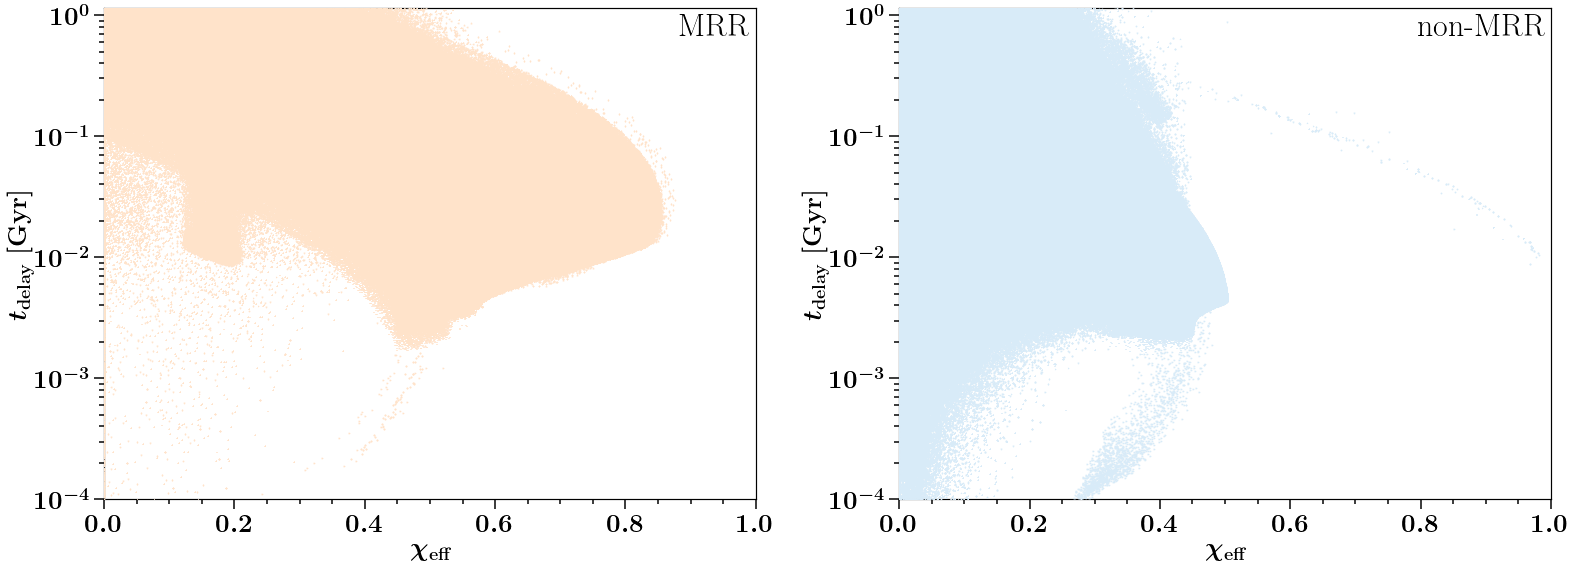

In [5]:


spin_threshold=0.05
xparam='ChiEff_vs_tdelay'


fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,2, figsize=(22,8))
mssfr = '112' # mssfr that matches LIGO observed rates.

nameX = r'$\chi_{\rm{eff}}$'
nameY = r'$t_{\rm{delay}} \ [\rm{Gyr}]$'




for model in ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
    print('now at model %s'%model)
    
    which='allMRR'
    _ = plot_Fig_GWTC(axe=axe[0], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)

    which='allNonMRR'
    _ = plot_Fig_GWTC(axe=axe[1], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)




for ax_ind, which in enumerate(['allMRR', 'allNonMRR']):
    
    make_up_axes(axes=axe[ax_ind], logY=True, logX=False) 
        
    axe[ax_ind].set_ylim(0.0001, np.log10(14)) 
    axe[ax_ind].set_xlim(0.0, 1)    
    axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=1, fontsize=fs_l+6)

    if which == 'allMRR':
        axe[ax_ind].text(1-0.009, 1-0.009, '{MRR}  ' , rotation = 0, fontsize = fs+8, color = 'k', ha = 'right', va='top', transform=axe[ax_ind].transAxes, zorder=100)#, weight = 'bold')
    else:
        axe[ax_ind].text(1-0.009, 1-0.009, '{non-MRR}' , rotation = 0, fontsize = fs+8, color = 'k', ha = 'right', va='top', transform=axe[ax_ind].transAxes, zorder=100)#, weight = 'bold')


plt.tight_layout()
plt.subplots_adjust(wspace=0.22, hspace=0)#2)

   
plt.savefig('./' + xparam + '_' + '2Dplot_' + 'priorWeighted_notdrawing.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    

# Figure 10 seperated by model 

now at model A
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


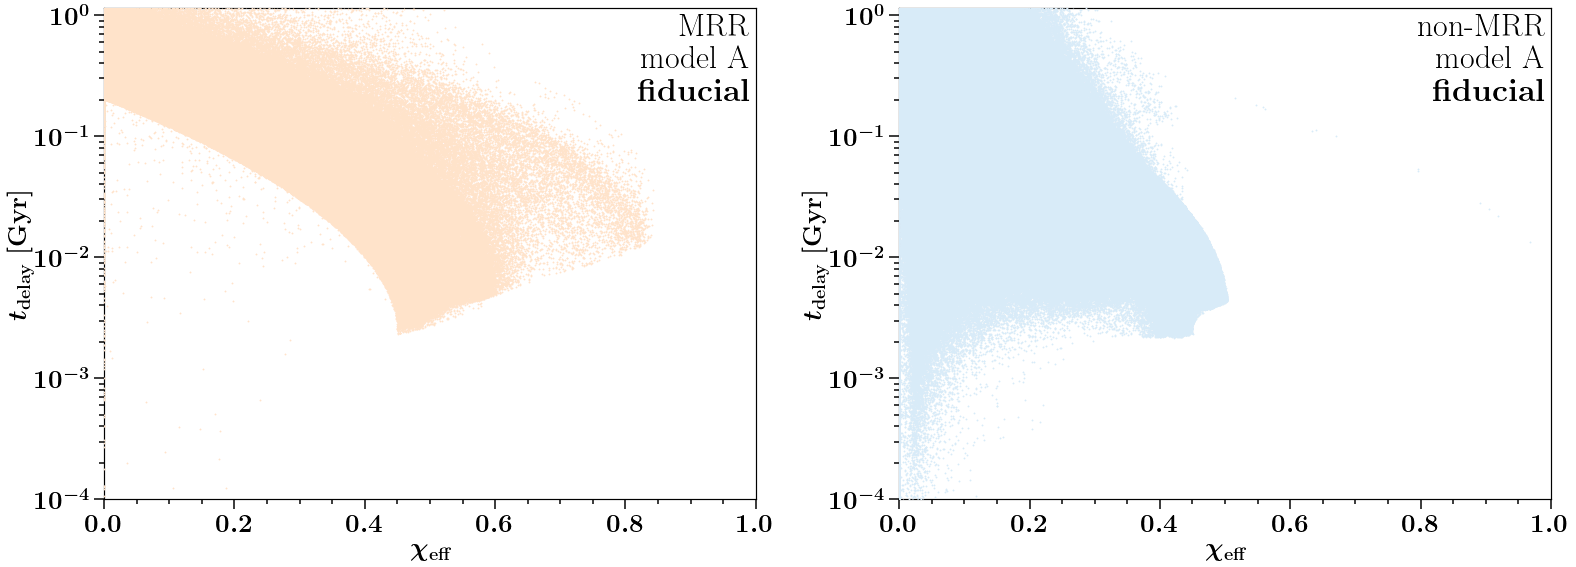

now at model C
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


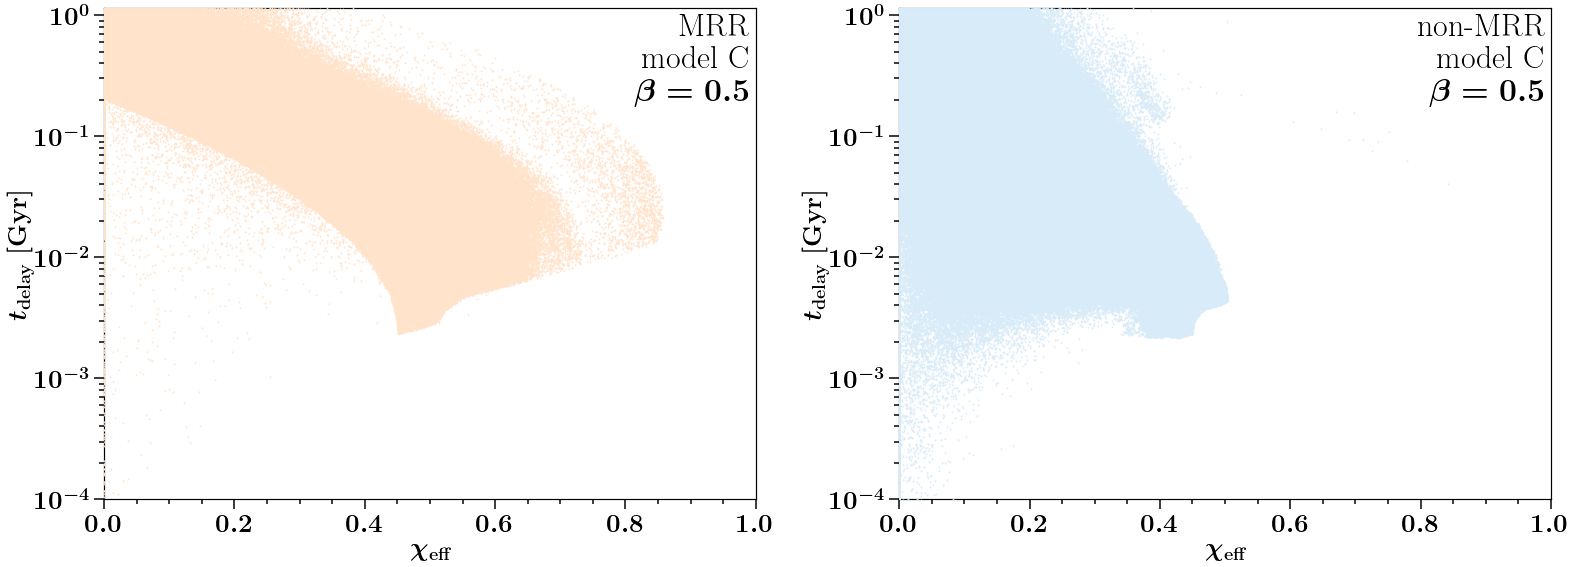

now at model D
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


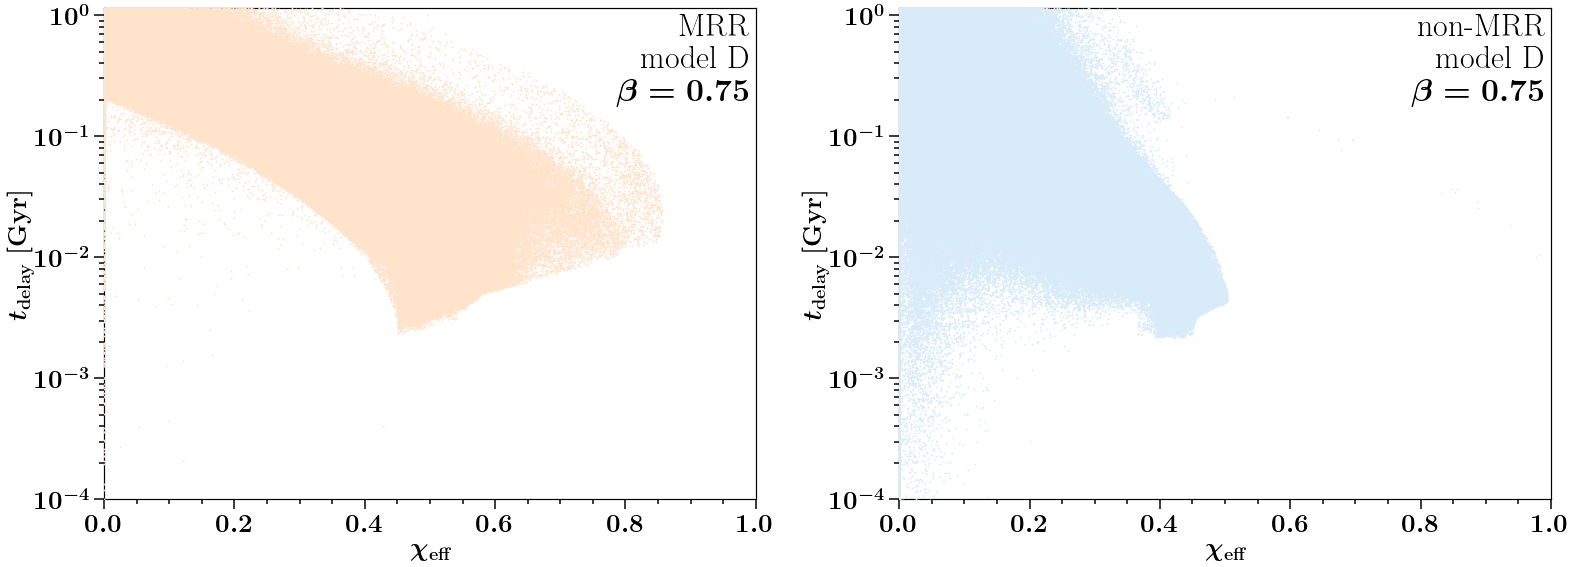

now at model E
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


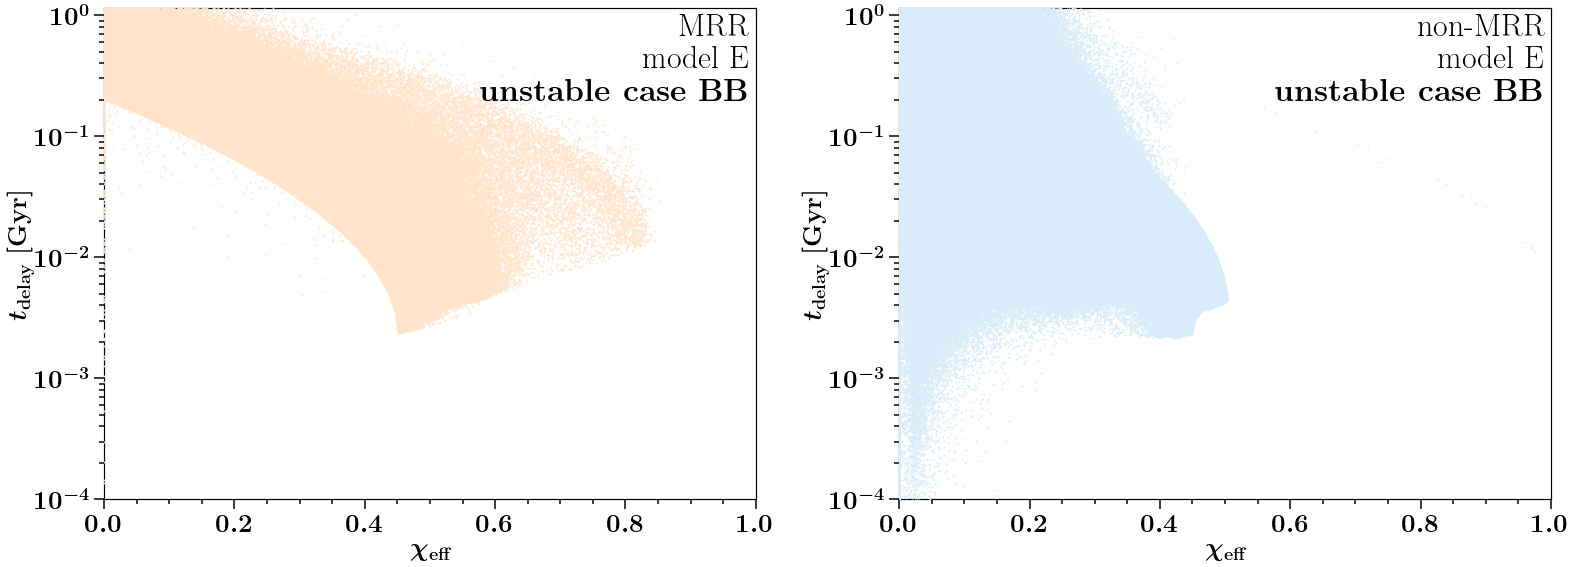

now at model F
140  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
140  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


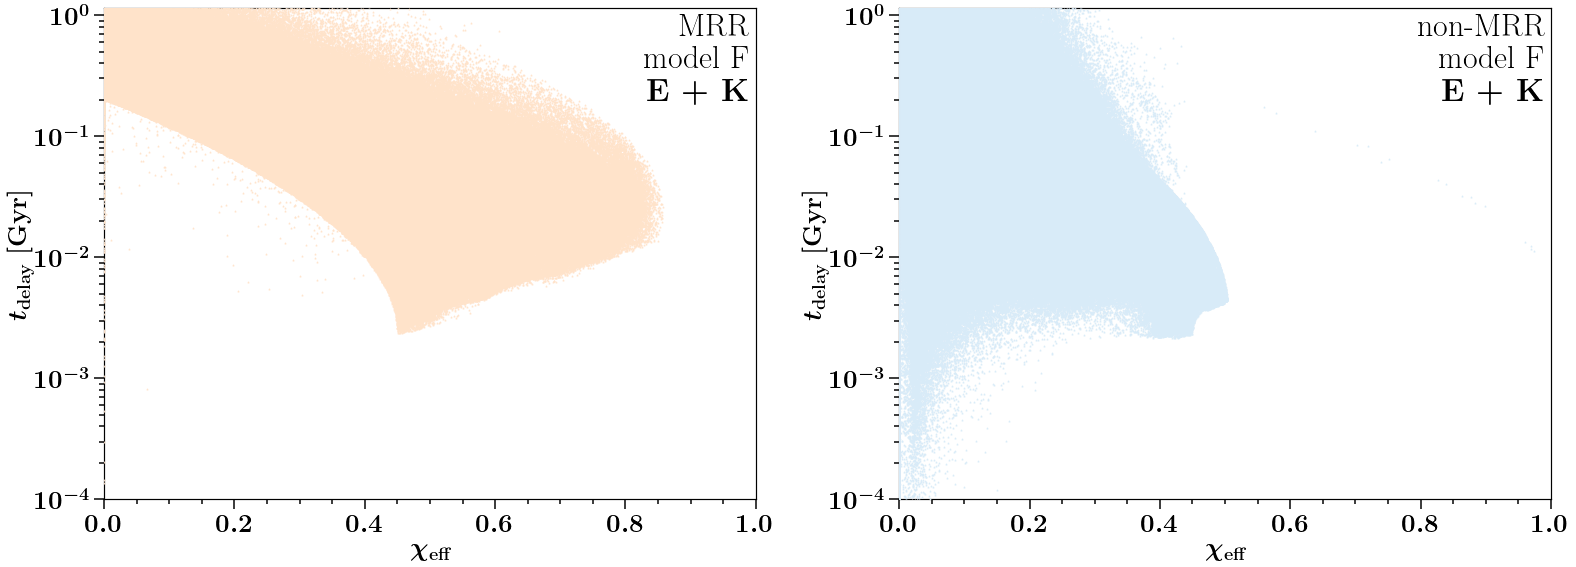

now at model G
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


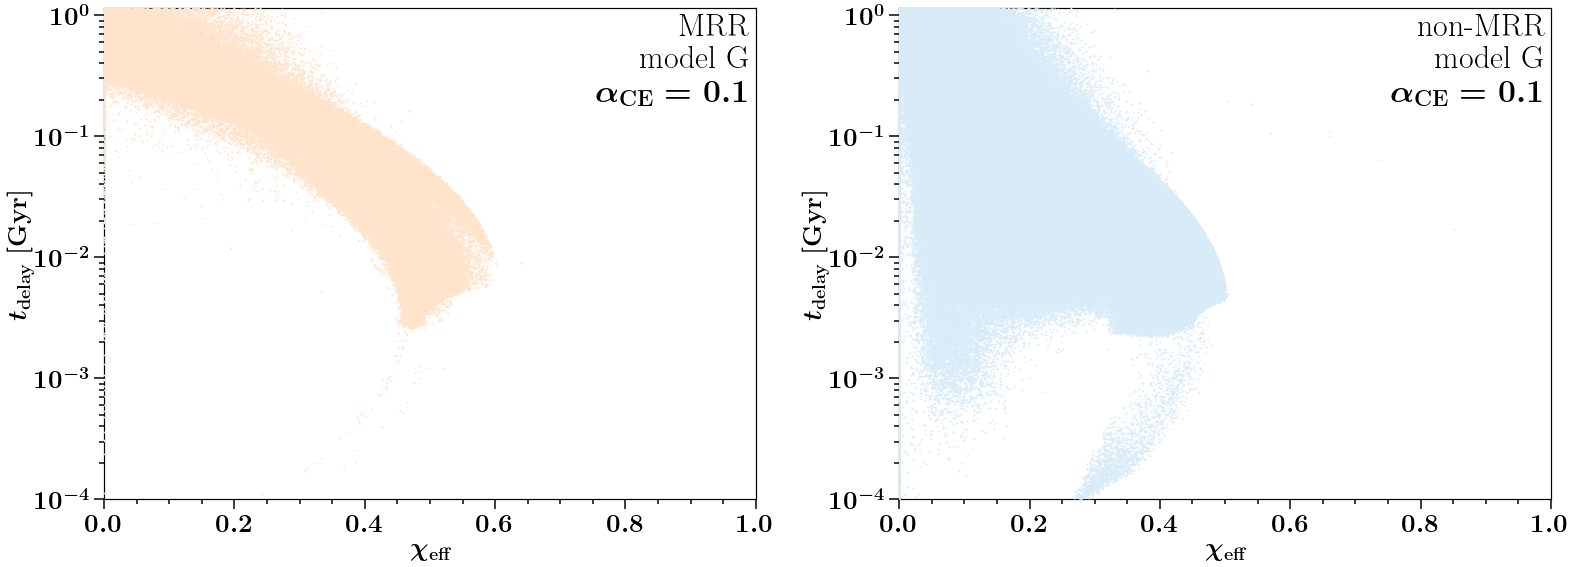

now at model H
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


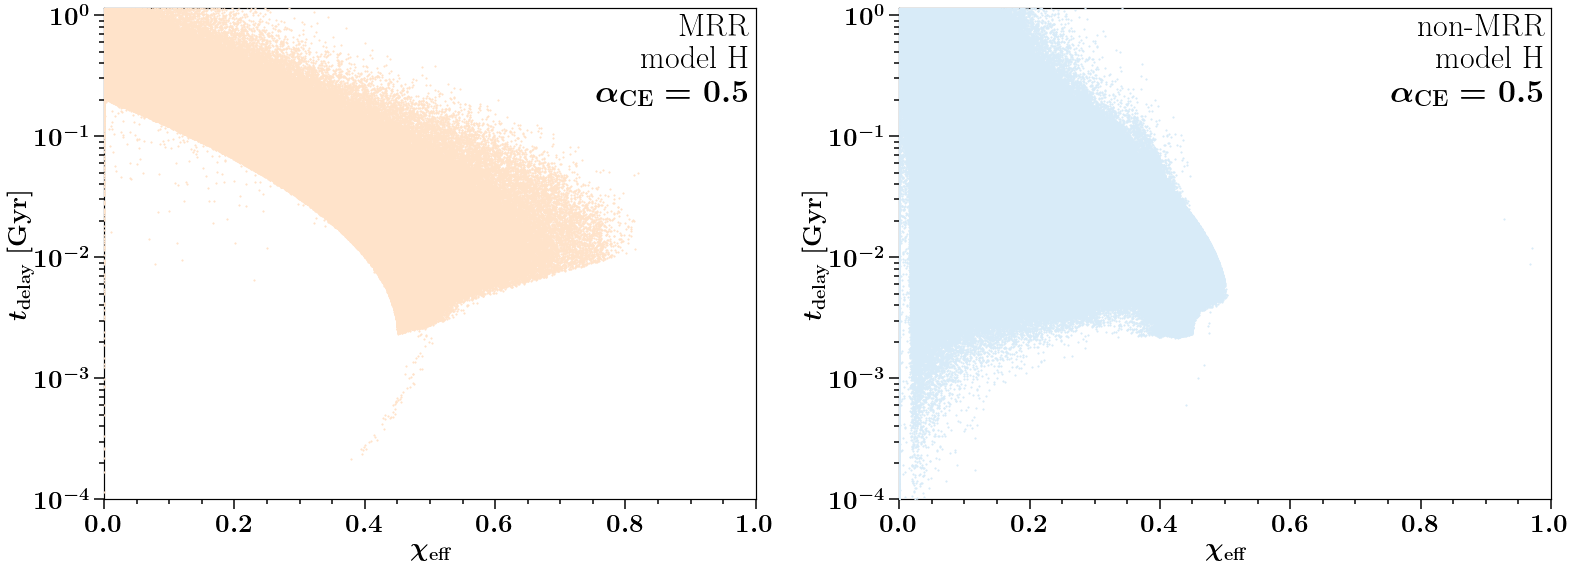

now at model I
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


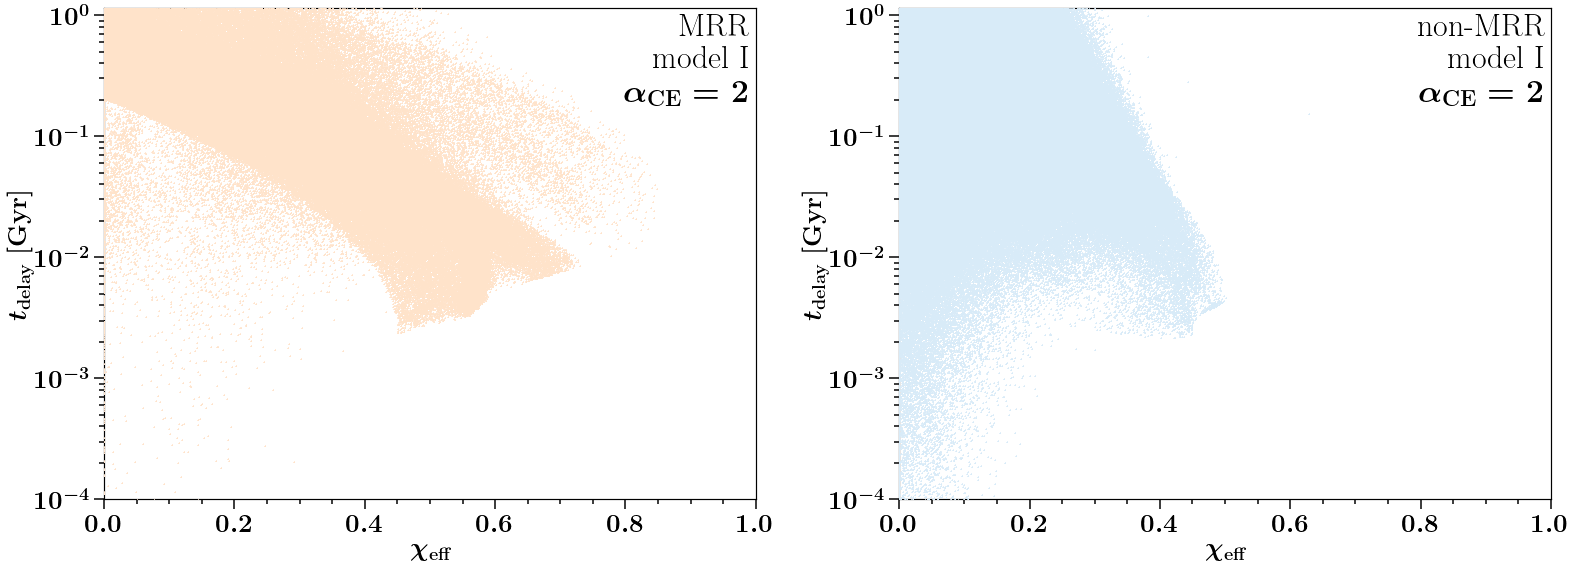

now at model J
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


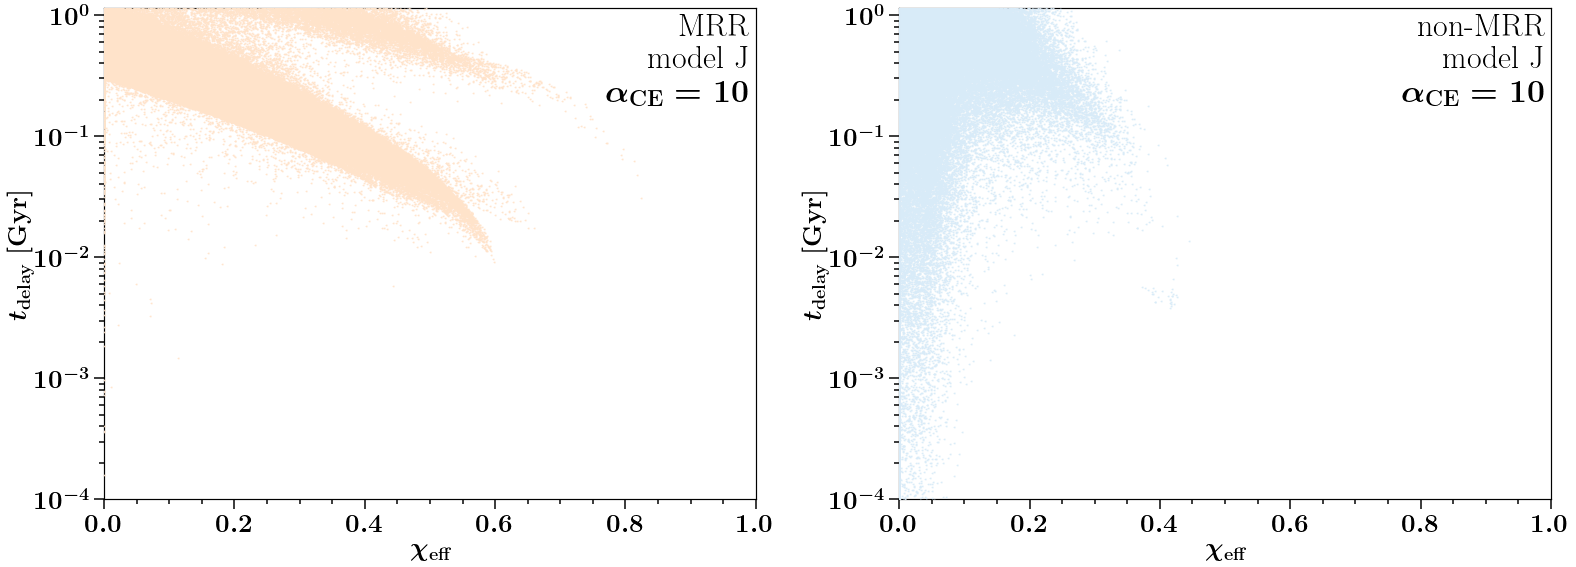

now at model K
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


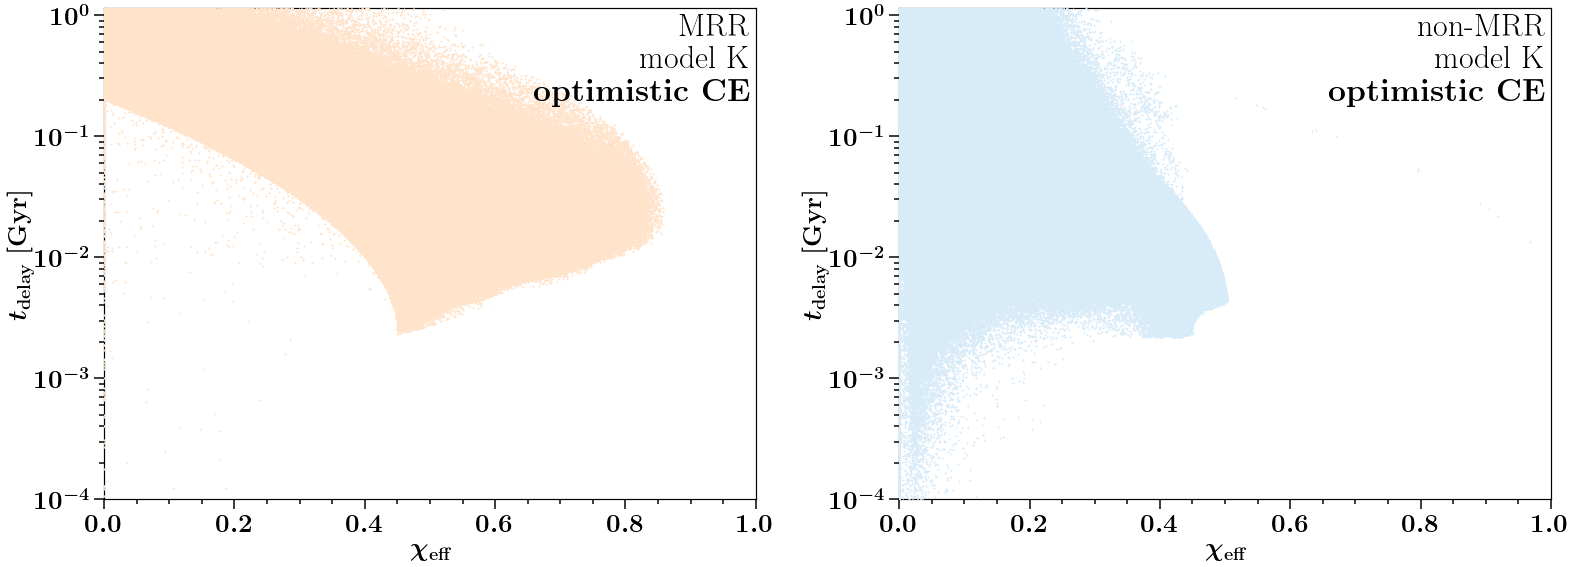

now at model L
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


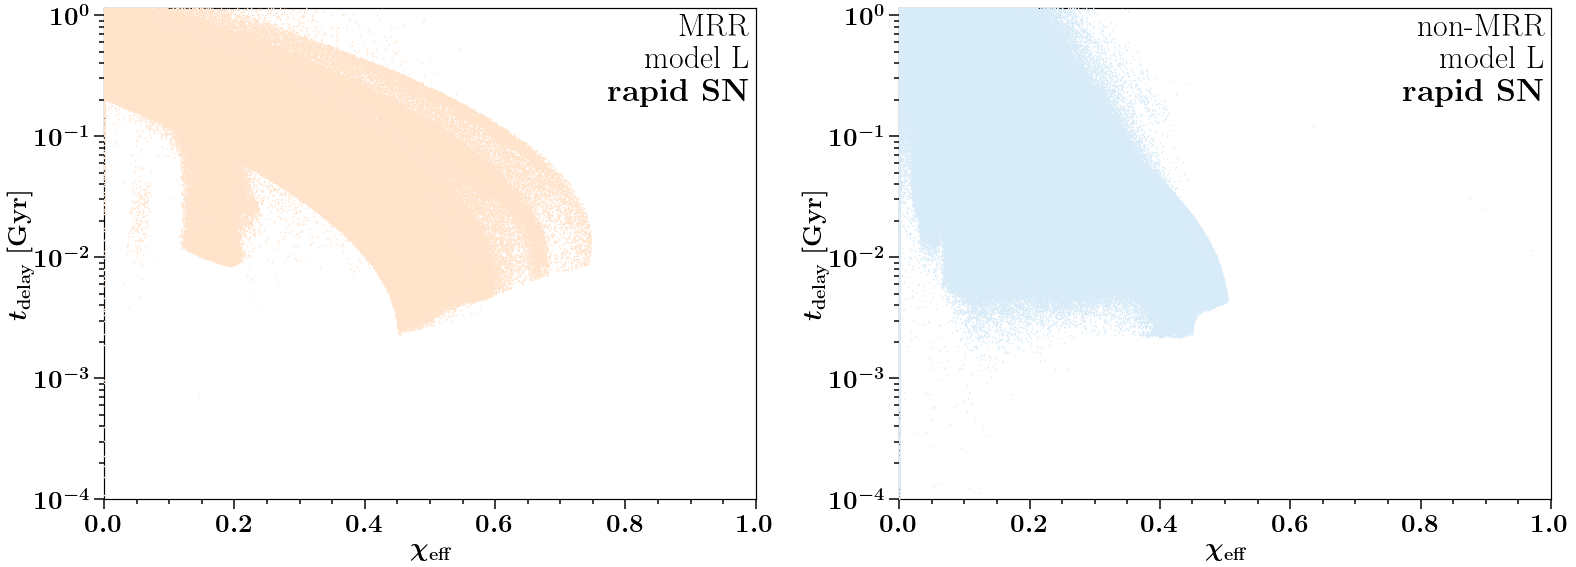

now at model M
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


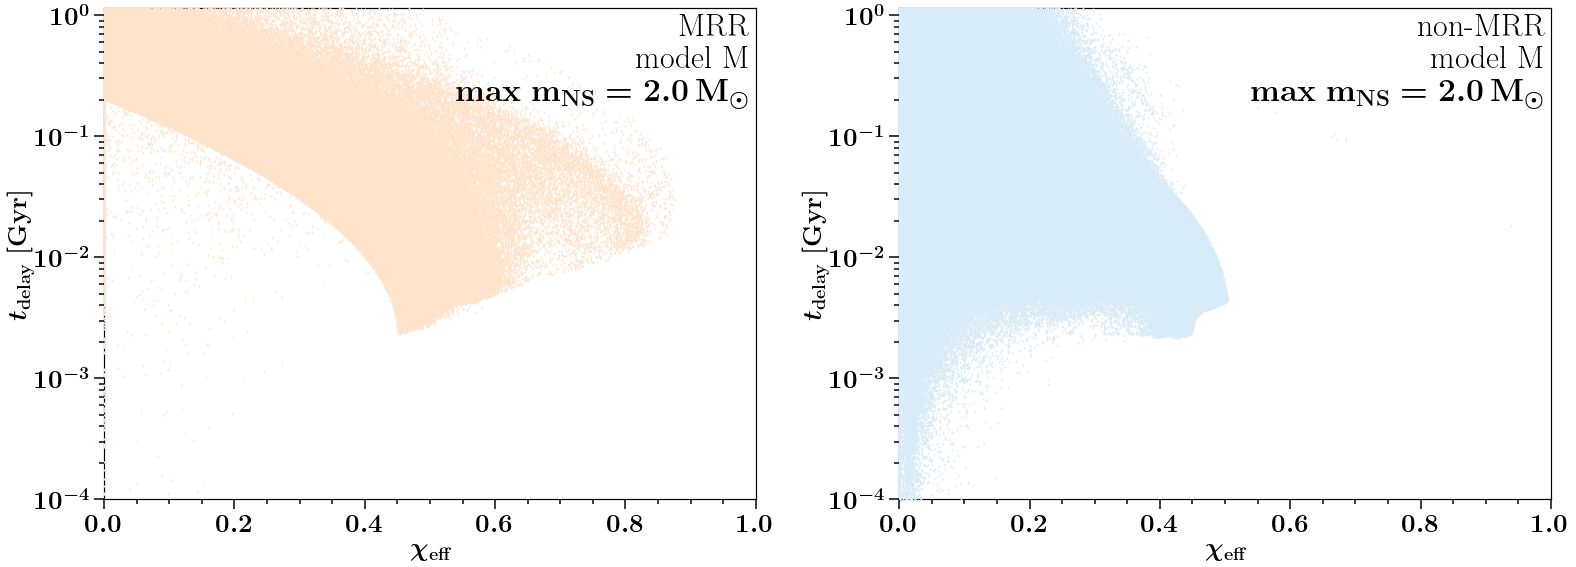

now at model N
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


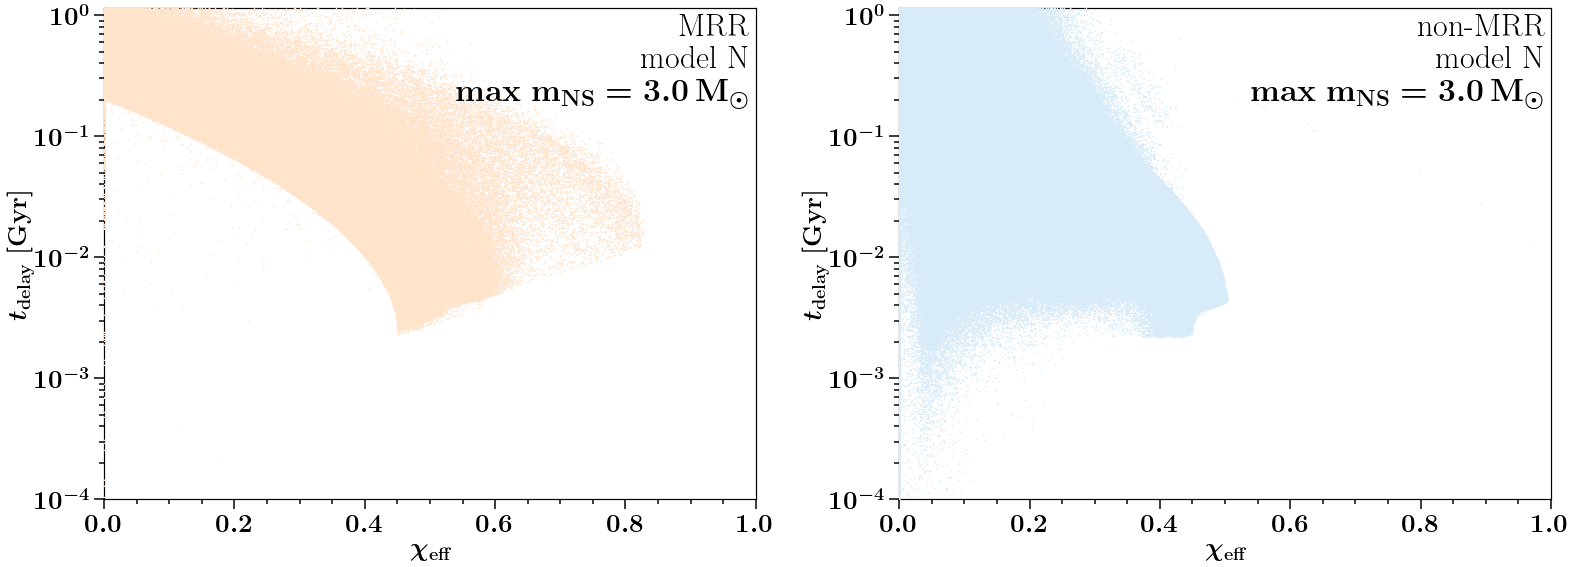

now at model O
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


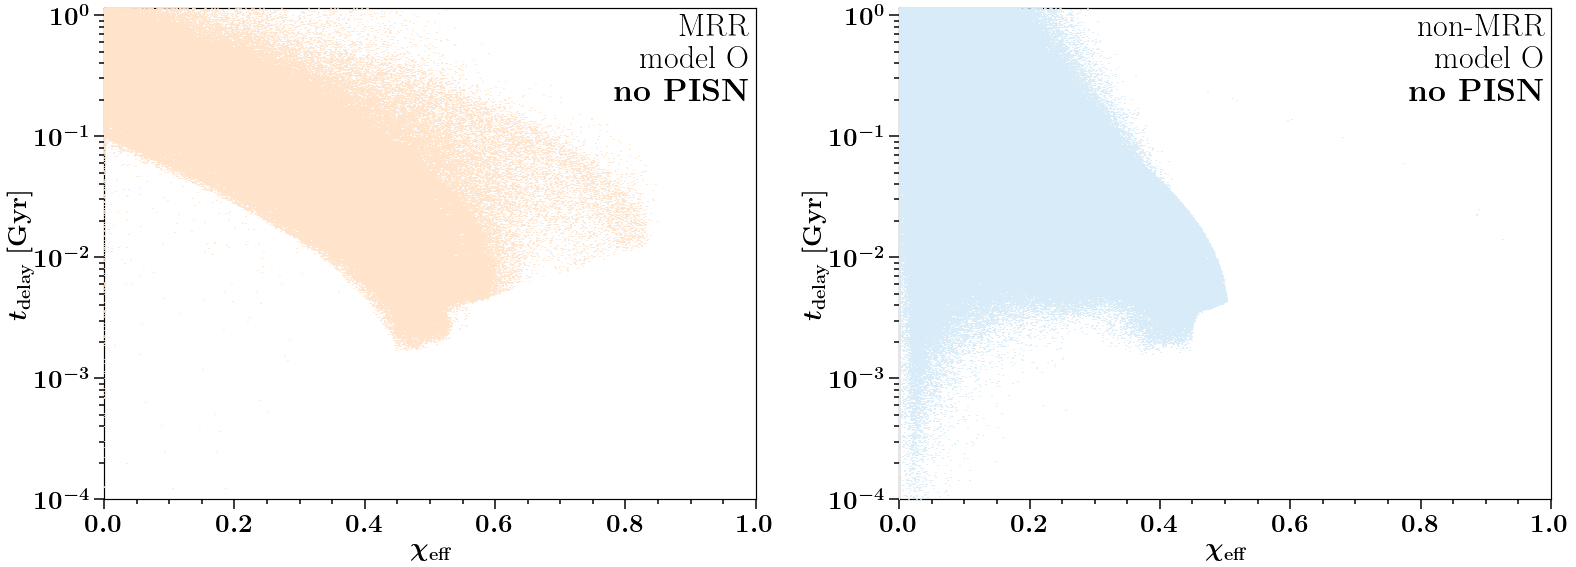

now at model P
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


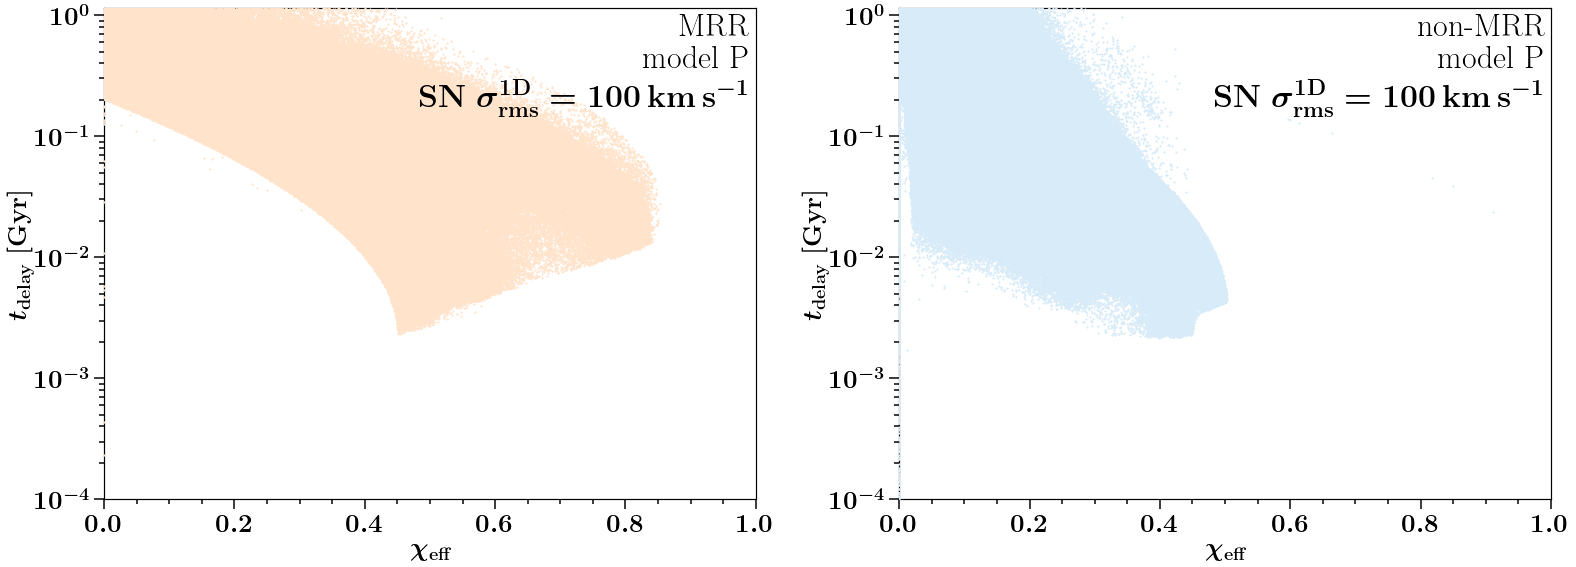

now at model Q
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


In [ ]:


spin_threshold=0.05
xparam='ChiEff_vs_tdelay'


fs_l = 20 # label fontsize

mssfr = '112' # mssfr that matches LIGO observed rates.

nameX = r'$\chi_{\rm{eff}}$'
nameY = r'$t_{\rm{delay}} \ [\rm{Gyr}]$'




for model in ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
    
    fig, axe = plt.subplots(1,2, figsize=(22,8))
    print('now at model %s'%model)
    
    which='allMRR'
    _ = plot_Fig_GWTC(axe=axe[0], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)

    which='allNonMRR'
    _ = plot_Fig_GWTC(axe=axe[1], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)




    for ax_ind, which in enumerate(['allMRR', 'allNonMRR']):


    #     plot_GW_contours_all(axe=axe[ax_ind], xparam=xparam, GW_highlight=GWhighlight)
    #     plot_3Msun_lines(axes=axe[ax_ind], xlim=[2,400])

        make_up_axes(axes=axe[ax_ind], logY=True, logX=False) 

    #     plot_x_ticks(axe=axe[ax_ind], xlim=[0,1], ylim=[-3,5], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  

        axe[ax_ind].set_ylim(0.0001, np.log10(14)) 
        axe[ax_ind].set_xlim(0.0, 1)    
        axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=1, fontsize=fs_l+6)
        
        if which == 'allMRR':
            axe[ax_ind].text(1-0.009, 1-0.009, '{MRR} \n model %s \n %s '%(model,alphabetPhysicalNameDict[model]) , rotation = 0, fontsize = fs+8, color = 'k', ha = 'right', va='top', transform=axe[ax_ind].transAxes, zorder=100)#, weight = 'bold')
        else:
            axe[ax_ind].text(1-0.009, 1-0.009, '{non-MRR} \n model %s \n %s '%(model,alphabetPhysicalNameDict[model]) , rotation = 0, fontsize = fs+8, color = 'k', ha = 'right', va='top', transform=axe[ax_ind].transAxes, zorder=100)#, weight = 'bold')




    plt.tight_layout()
    

    plt.subplots_adjust(wspace=0.22, hspace=0)#2)


    plt.savefig('./chieff_tdelay_per_model/' + xparam + '_' + '2Dplot_' + 'priorWeighted_'+ model+ '.png', transparent=False, bbox_inches="tight", dpi=300)
    plt.show() 

    
    

    
    
    
    
    
    
    

## Figure 7 PLOT MRR vs non MRR contours 

In [ ]:


spin_threshold=0.05
xparam='Mtot_vs_q'

GWhighlight =  [r'GW151226', r'GW170729', r'GW190412', 'GW191204_110529', 'GW190924_021846', 'GW190521']


fs_l = 26 # label fontsize
fig, axe = plt.subplots(1,2, figsize=(22,8))
mssfr = '112' # mssfr that matches LIGO observed rates.

nameX = r'$m_{\rm{tot}} \ [\rm{M}_{\odot}]$'
nameY = r'$q$'


for ax_ind, which in enumerate(['allNonMRR']):
    
    
    plot_GW_contours_all(axe=axe[ax_ind], xparam=xparam, GW_highlight=GWhighlight)
    plot_3Msun_lines(axes=axe[ax_ind], xlim=[2,400])

    make_up_axes(axes=axe[ax_ind], logY=False) 
    
    plot_x_ticks(axe=axe[ax_ind], xlim=[4,400], ylim=[-1,1], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
    
    axe[ax_ind].set_ylim(0, 1) 
    axe[ax_ind].set_xlim(4, 400)    
    axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=1, fontsize=fs_l+6)


plt.tight_layout()
plt.subplots_adjust(wspace=0.12, hspace=0)#2)

   
# plt.savefig('./Mtot_vs_q_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    

# Figure 7: q versus total mass

In [ ]:


spin_threshold=0.05
xparam='Mtot_vs_q'
GWlist = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', \
                    'GW170814', 'GW170818', 'GW170823', 'GW190408_181802', 'GW190412', 'GW190413_052954',\
                    'GW190413_134308', 'GW190421_213856', 'GW190424_180648', 'GW190503_185404', 'GW190512_180714', \
                    'GW190513_205428', 'GW190514_065416', 'GW190517_055101', 'GW190519_153544', 'GW190521', \
                    'GW190521_074359', 'GW190527_092055', 'GW190602_175927', 'GW190620_030421', 'GW190630_185205', \
                    'GW190701_203306', 'GW190706_222641', 'GW190707_093326', 'GW190708_232457', 'GW190719_215514',\
                    'GW190720_000836', 'GW190727_060333', 'GW190728_064510', 'GW190731_140936', 'GW190803_022701',\
                    'GW190814', 'GW190828_063405', 'GW190828_065509', 'GW190910_112807', 'GW190915_235702', \
                    'GW190924_021846', 'GW190929_012149', 'GW190930_133541', 'GW191103_012549', 'GW191105_143521',\
                    'GW191109_010717', 'GW191113_071753', 'GW191126_115259', 'GW191127_050227', 'GW191129_134029', \
                    'GW191204_110529', 'GW191204_171526', 'GW191215_223052', 'GW191216_213338', 'GW191222_033537', \
                    'GW191230_180458', 'GW200112_155838', 'GW200128_022011', 'GW200129_065458', 'GW200202_154313', \
                    'GW200208_130117', 'GW200208_222617', 'GW200209_085452', 'GW200210_092254', 'GW200216_220804', \
                    'GW200219_094415', 'GW200220_061928', 'GW200220_124850', 'GW200224_222234', 'GW200225_060421',\
                    'GW200302_015811', 'GW200306_093714', 'GW200308_173609', 'GW200311_115853', 'GW200316_215756', 'GW200322_091133']


print(len(GWlist))
GWlist = ['GW191204_110529']

GWhighlight_MRR = ['GW190513_205428', 'GW191204_110529', 'GW191215_223052', 'GW200306_093714']
GWhighlight_nonMRR = ['GW190924_021846', 'GW191129_134029','GW200202_154313' ]
GWhighlight_MRR = [ 'GW191204_110529']
GWhighlight_nonMRR = ['GW190924_021846' ]
GWhighlight =  [r'GW151226', r'GW170729', r'GW190412', 'GW191204_110529', 'GW190924_021846', 'GW190521']


fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,2, figsize=(22,8))
mssfr = '112' # mssfr that matches LIGO observed rates.

nameX = r'$m_{\rm{tot}} \ [\rm{M}_{\odot}]$'
nameY = r'$q$'



for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A']:
    print('now at model %s'%model)
    
    which='allMRR'
    _ = plot_Fig_GWTC(axe=axe[0], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)

    which='allNonMRR'
    _ = plot_Fig_GWTC(axe=axe[1], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)




for ax_ind, which in enumerate(['allMRR', 'allNonMRR']):
    
    
    plot_GW_contours_all(axe=axe[ax_ind], xparam=xparam, GW_highlight=GWhighlight)
    plot_3Msun_lines(axes=axe[ax_ind], xlim=[2,400])

    make_up_axes(axes=axe[ax_ind], logY=False) 
    
    plot_x_ticks(axe=axe[ax_ind], xlim=[4,400], ylim=[-1,1], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
    
    axe[ax_ind].set_ylim(0, 1) 
    axe[ax_ind].set_xlim(4, 400)    
    axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=1, fontsize=fs_l+6)


plt.tight_layout()
plt.subplots_adjust(wspace=0.12, hspace=0)#2)

   
plt.savefig('./Mtot_vs_q_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    

# Figure 8 

In [ ]:



spin_threshold=0.05
xparam='ChirpMass_vs_ChiEff'



fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,2, figsize=(22,8))
mssfr = '112' # mssfr that matches LIGO observed rates.

nameX = r'\textbf{Chirp mass} $\mathcal{M} \ [\rm{M}_{\odot}]$'
nameY = r'\textbf{Effective inspiral spin } $\chi_{\rm{eff}}$'


for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A']:
    print('now at model %s'%model)
    
    which='allMRR'
    _ = plot_Fig_GWTC(axe=axe[0], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)

    which='allNonMRR'
    _ = plot_Fig_GWTC(axe=axe[1], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)




for ax_ind, which in enumerate(['allMRR', 'allNonMRR']):
    
    
#     plot_GW_contours(axe=axe[ax_ind], xparam=xparam, which=which)
        
    plot_GW_contours_all(axe=axe[ax_ind], xparam=xparam, GW_highlight=GWhighlight)

    
    axe[ax_ind].plot([1,100], [0,0], lw=1, ls=':', c='k') # plot line around 0 

    make_up_axes(axes=axe[ax_ind], logY=False) 
    plot_x_ticks(axe=axe[ax_ind], xlim=[2,100], ylim=[-0.2,1], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
    axe[ax_ind].set_ylim(-0.2, 1) 
    axe[ax_ind].set_xlim(2, 100)
    
    axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=1, fontsize=fs_l+4)



plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0)#2)

   
plt.savefig('./ChirpMass_vs_ChiEff_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    

# Figure 9 

In [ ]:



spin_threshold=0.05
xparam='ChiEff_vs_q'



fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,2, figsize=(22,8))
mssfr = '112' # mssfr that matches LIGO observed rates.

nameY = r'\textbf{Mass ratio} $q$'
nameX = r'\textbf{Effective inspiral spin } $\chi_{\rm{eff}}$'

for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
    print('now at model %s'%model)
    
    which='allMRR'
    _ = plot_Fig_GWTC(axe=axe[0], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)

    which='allNonMRR'
    _ = plot_Fig_GWTC(axe=axe[1], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)




for ax_ind, which in enumerate(['allMRR', 'allNonMRR']):

    make_up_axes(axes=axe[ax_ind], logY=False, logX=False) 
    plot_x_ticks(axe=axe[ax_ind], xlim=[-0.2,1], ylim=[0,1], tick_fs=20, xtick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
    axe[ax_ind].set_ylim(0, 1) 
    axe[ax_ind].set_xlim(-0.05, 1)
  
    axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=1, fontsize=fs_l+4)



plt.tight_layout()
plt.subplots_adjust(wspace=0.13, hspace=0)#2)

   
plt.savefig('./' + xparam + '_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    

In [ ]:
def plot_3Msun_lines(axes, xlim=[1,100]):
    
    # m1 = 3 Msun 
#     q = np.linspace(0, 1, 100)
#     m1 = 2
#     mtot = (q+1) * m1
    
#     axes.plot(mtot, q, c='gray', lw=2, linestyle=':', zorder=1E4)
#     axes.text(mtot[11], q[10], s=r'$m_1 = 3 \, \rm{M}_{\odot}$', fontsize=fs-6, rotation=72, va='bottom', ha='center')
        
    # m2 = 3 Msun 
    q=np.linspace(0.001, 1, 100)
    m2 = 2 # Msun 
    mtot = (1+(1/q))*m2
    axes.plot(mtot, q, c='gray', lw=2, linestyle=':', zorder=1E4)
    axes.text(mtot[2], q[3], s=r'$m_2 = 2 \, \rm{M}_{\odot}$', fontsize=fs-6, rotation=-3)
    

    return


def make_up_axes(axes=None, xlim=[2,400], ylim=[0,1], xlabel=None, ylabel=None, logX=True,  logY=False):
    
    
    if (xlabel!=None) & (ylabel!=None):
        layoutAxes(ax=axes, nameX=xlabel, nameY=ylabel, labelpad=20)
    elif xlabel==None:
        layoutAxesNoXlabel(ax=axes, nameX=xlabel, nameY=ylabel, labelpad=20)
    elif ylabel==None:
        layoutAxesNoYlabel(ax=axes, nameX=xlabel, nameY=ylabel, labelpad=20)    
        
#     axes.set_xlim(xlim[0],xlim[1])
#     axes.set_ylim(ylim[0], ylim[1])
    
    if logX!=False:
        axes.set_xscale('log')     
    if logY!=False:
        axes.set_yscale('log')       
    return 




def plot_x_ticks(axe=None, xtick_loc=[1, 2, 4, 7, 10, 20, 40, 70, 100, 200, 400], ytick_loc=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], xlim=[2,400], ylim=[0,1],tick_fs=20):
    

    fs = 18
    xtick_name = []
    for ind, xtick in enumerate(xtick_loc):
        xtick_name.append(r'${%s}$'%str(xtick))
        axe.plot(np.ones(100)*xtick, np.linspace(ylim[0], ylim[1], 100), c='lightgray', lw=1.2, linestyle='-', zorder=0)
    
    axe.set_xticks(xtick_loc)
    axe.set_xticklabels(xtick_name, fontsize=tick_fs, rotation=0)#, orientation=30) 
    
    
    ytick_name = []
    for ind, ytick in enumerate(ytick_loc):
        ytick_name.append(r'${%s}$'%str(ytick))
        axe.plot(np.linspace(xlim[0], xlim[1], 100), np.ones(100)*ytick, c='lightgray', lw=1.2, linestyle='-', zorder=0)
    
    axe.set_yticks(ytick_loc)
    axe.set_yticklabels(ytick_name, fontsize=tick_fs, rotation=0)#, orientation=30)  
    
    axe.set_xlim(xlim[0], xlim[1])
    axe.set_ylim(ylim[0], ylim[1])

    return 



def plot_GW_contours_all(axe, xparam, GW_highlight):


#     GWtotal = np.concatenate((np.concatenate((GW_highlight_MRR, GW_highlight_nonMRR)), GW_list))
    for ind, GW_name in enumerate(GW_highlight):
        print(GW_name)
        
        dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
        dfCSVname_ = dfCSVname + 'posteriorSamples_' + GW_name  + '.csv' 


        df = pd.read_csv(dfCSVname_, index_col=0, skiprows=[1])
        mass_ratio = df['M2']/df['M1']
        total_mass = df['M2'] + df['M1']
        spin1 = df['spin1'] 
        spin2 = df['spin2'] 
        
        chi_eff = df['chi_eff']
        chirp_mass = chirpmass(df['M2'], df['M1'])
        
  
        c_highlight= 'k'
        c_highlight_nonMRR = 'k'
        c_gray = 'lightgray'

        
#         if GW_name in GW_highlight_MRR:
        zorder = 115
        color=c_highlight
#         elif GW_name in GW_highlight_nonMRR:
#             zorder=115
#             color = c_highlight_nonMRR
#         else: 
#             zorder=110 
#             color = c_gray
            
        print(GW_name, ' total mass = ', np.median(total_mass) )
        print(GW_name, ' chirp mass = ', np.median(chirp_mass) )
        if xparam=='Mtot_vs_q':
             sns.kdeplot(x=total_mass, y=mass_ratio, levels=[0.1], zorder=zorder, color=color,ax=axe) 
                
        elif xparam=='ChirpMass_vs_ChiEff':
            sns.kdeplot(x=chirp_mass, y=chi_eff, levels=[0.1], zorder=zorder, color=color,ax=axe) 

        elif xparam=='ChiEff_vs_q':                
            sns.kdeplot(x=chi_eff, y=mass_ratio, levels=[0.1], zorder=zorder, color=color,ax=axe) 

            
            
            
            
def plot_GW_contours(axe, xparam, which):

    GW_list = ['GW151226','GW170729', 'GW190517_055101', 'GW190412'] #,'GW191109_010717'  ,'GW191103_012549', 'GW191126_115259']


    for ind, GW_name in enumerate(GW_list):
        print(GW_name)
        
        dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
        dfCSVname_ = dfCSVname + 'posteriorSamples_' + GW_name  + '.csv' 


        df = pd.read_csv(dfCSVname_, index_col=0, skiprows=[1])
        mass_ratio = df['M2']/df['M1']
        total_mass = df['M2'] + df['M1']
        spin1 = df['spin1'] 
        spin2 = df['spin2'] 
        
        chi_eff = df['chi_eff']
        chirp_mass = chirpmass(df['M2'], df['M1'])
        
  
        

        if xparam=='Mtot_vs_q':
            sns.kdeplot(x=total_mass, y=mass_ratio, levels=[0.1], zorder=11, color='k',ax=axe)
            mask_spin2 = (abs(spin2)<0.05) & (spin1>0.05) # MRR spin1 is the spinning one, we want the other one to be zero
            mask_spin1 = (abs(spin1)<0.05) & (spin2>0.05)# non MRR, spin 2 is the spinning one, we want spin1 to be zero  
            if which== 'allMRR':
                sns.kdeplot(x=total_mass[mask_spin2], y=mass_ratio[mask_spin2], kde_kws=dict(linestyle=':', linewidth=5), levels=[0.1], zorder=12, color=colors[1],ax=axe)
            elif which== 'allNonMRR':    
                sns.kdeplot(x=total_mass[mask_spin1], y=mass_ratio[mask_spin1], levels=[0.1], zorder=12, color=colors[0], kde_kws=dict(linestyle=':', linewidth=3),ax=axe)

                
        elif xparam=='ChirpMass_vs_ChiEff':
            sns.kdeplot(x=chirp_mass, y=chi_eff, levels=[0.1], zorder=11, color='k', ax=axe)
            mask_spin2 = abs(spin2)<0.05 # MRR spin1 is the spinning one, we want the other one to be zero
            mask_spin1 = abs(spin1)<0.05 # non MRR, spin 2 is the spinning one, we want spin1 to be zero 
            if which== 'allMRR':
                sns.kdeplot(x=chirp_mass[mask_spin2], y=chi_eff[mask_spin2], kde_kws=dict(linestyle=':', linewidth=5), levels=[0.1], zorder=12, color=colors[1],ax=axe)
            elif which== 'allNonMRR':     
                sns.kdeplot(x=chirp_mass[mask_spin1], y=chi_eff[mask_spin1], levels=[0.1], zorder=12, color=colors[0], kde_kws=dict(linestyle=':', linewidth=3),ax=axe)
          
        
        elif xparam=='ChiEff_vs_q':
            sns.kdeplot(x=chi_eff, y=mass_ratio, levels=[0.1], zorder=11, color='k', ax=axe)

            mask_spin2 = (abs(spin2)<0.05) & (spin1>0.05) # MRR spin1 is the spinning one, we want the other one to be zero
            mask_spin1 = (abs(spin1)<0.05) & (spin2>0.05)# non MRR, spin 2 is the spinning one, we want spin1 to be zero  
            if which== 'allMRR':
                sns.kdeplot(x=chi_eff[mask_spin2], y=mass_ratio[mask_spin2], kde_kws=dict(linestyle=':', linewidth=5), levels=[0.1], zorder=12, color=colors[1],ax=axe)
            elif which== 'allNonMRR':     
                sns.kdeplot(x=chi_eff[mask_spin1], y=mass_ratio[mask_spin1], levels=[0.1], zorder=12, color=colors[0], kde_kws=dict(linestyle=':', linewidth=3),ax=axe)
            
            



def plot_Fig_GWTC(axe, xparam='chiEff', BPSmodelName='A', mssfr='112', which='allMRR'):
    
    labellist= np.ones(5) #,  r'$\log_{10}(t) $']      

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda2/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(path, 'r')
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    seedsDCO  = fdata['doubleCompactObjects']['seed'][...].squeeze()  # get the seeds in the DCO file 
    seedsSN   = fdata['supernovae']['randomSeed'][...].squeeze()    # get the seeds in the SN file 
    indices   = np.sort(np.unique(seedsSN[1::2], return_index=True)[1])
    maskSNdco = np.in1d(seedsSN,  seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
    whichSN   = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]  # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova     
    whichSN2  = whichSN[1::2][indices]

    # either SN2 = primary (1) and M1 is > M2, or SN2 = secondary & M1 < M2 
    # this takes into account (first term) rejuvenation 
    mask_MRR = ((whichSN2==1) & (massCO_ZAMSM1>massCO_ZAMSM2) ) | ((whichSN2==2) & (massCO_ZAMSM1<massCO_ZAMSM2)) 

    del whichSN2
    del whichSN
    del maskSNdco
    del indices
    del seedsSN
    del seedsDCO

    spin = COspin(data_path=path, state='he_depletion')  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 

    spinLVKM1, spinLVKM2 = np.zeros_like(spinZAMSM1), np.zeros_like(spinZAMSM1)
    spinLVKM1[mask_MRR] = spinZAMSM2[mask_MRR]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
    spinLVKM1[~mask_MRR] = spinZAMSM1[~mask_MRR]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
    spinLVKM2[mask_MRR] = spinZAMSM1[mask_MRR]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
    spinLVKM2[~mask_MRR] = spinZAMSM2[~mask_MRR]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     

    # spin_threshold = 0.05 # definition of "spinning BH"
    mask_LVKM1_spinning = (spinLVKM1 > spin_threshold ) # more massive = spinning: MRR 
    mask_LVKM2_spinning = (spinLVKM2 > spin_threshold ) # less nassuve BH = spinning (Non MRR)
    mask_anySpin = (spinLVKM1 > spin_threshold ) | (spinLVKM2 > spin_threshold )        

    M1LVK, M2LVK = massCO_LVKM1, massCO_LVKM2 
    chi_eff = ((spinLVKM1*M1LVK) + (spinLVKM2*M2LVK)) / (M1LVK + M2LVK)
    chirp_mass = chirpmass(M1LVK, M2LVK)
    mass_ratio_LVK =  M2LVK/M1LVK
    MRR_mask = mask_MRR

    if xparam=='ChirpMass_vs_ChiEff':
        chi_eff = ((spinZAMSM1 *massCO_ZAMSM1) + spinZAMSM2*massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2) 
        param_y = chi_eff
    elif xparam=='Mtot_vs_q':
        param_x = massCO_ZAMSM1 + massCO_ZAMSM2
        param_y = MassRatioCO_LVK        
    elif xparam=='ChiEff_vs_q':
        chi_eff = ((spinZAMSM1 *massCO_ZAMSM1) + spinZAMSM2*massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
        param_x = chi_eff 
        param_y = massCO_LVKM2 / massCO_LVKM1       
        
    
    NN_ = 1000
    size_ = 1
    size_big = 5
    Ndraw_temp = 100
    zorder=9  
    
    if (which=='allMRR') | (which=='allSpin1'):
        color_BPS =colors_lighter[1]
        color_scatter = colors[1]
    elif (which=='allNonMRR') | (which=='allSpin2'):
        color_BPS = colors_lighter[0]
        color_scatter = colors[0]
    elif which in ['perModelMRR', 'perModelNonMRR']:
        print('a')
        
        
        
#     color_BPS = [adjust_lightness(color= colorDirDict[BPSmodelName], amount=1.3)]
#     color_scatter = [colorDirDict[BPSmodelName]]
    size_big = 100
    

    if (which in  ['allMRR','perModelMRR', 'allSpin1']):

        if which in ['allMRR','perModelMRR']:
            axe.scatter(param_x[mask_MRR][:],    param_y[mask_MRR][:], s=size_, marker=dictMarkerShape[BPSmodelName], color=color_BPS, zorder=zorder) # all non MRR 
        elif which in ['allSpin1']:
            axe.scatter(param_x[mask_LVKM1_spinning][:],    param_y[mask_LVKM1_spinning][:], s=size_, marker=dictMarkerShape[BPSmodelName], color=color_BPS, zorder=zorder) # all non MRR 
            
#         colors_lighter_kde = [adjust_lightness(color=colors[0], amount=1.2),adjust_lightness(color=colors[1], amount=1.3)]
#         colors_lighter_kde_low = [adjust_lightness(color=colors[0], amount=1.2),adjust_lightness(color=colors[1], amount=1.9)]
#         cmapCustom = matplotlib.colors.LinearSegmentedColormap.from_list("", [colors_lighter_kde_low[1], colors_lighter_kde[1]])
#         sns.kdeplot(x=param_x[mask_LVKM1_spinning][:], y=param_y[mask_LVKM1_spinning][:], weights=w[mask_LVKM1_spinning][:], levels=[ 0.1,1], zorder=10, color='gray', fill=False, linewidth=2)
   
    elif (which in  ['allNonMRR','perModelNonMRR','allSpin2']):
        if which in ['allNonMRR','perModelNonMRR']:
            axe.scatter(param_x[~mask_MRR][:],    param_y[~mask_MRR][:], s=size_, marker=dictMarkerShape[BPSmodelName], color=color_BPS, zorder=zorder) # all non MRR 
        elif which in ['allSpin2']:
            axe.scatter(param_x[mask_LVKM2_spinning][:], param_y[mask_LVKM2_spinning][:], s=size_, marker=dictMarkerShape[BPSmodelName], color=color_BPS, zorder=zorder) # all non MRR 

            
    GW_list = ['GW151226','GW170729', 'GW190517_055101', 'GW190412']         
#     for ind_mssfr, mssfr  in enumerate([MSSFRnameslist[0]]):
    for ind_mssfr, mssfr  in enumerate(MSSFRnameslist[:]):
        ### read in MSSFR weights: ###
        # get detected weights
        fparam_key = 'weights_detected'
        weightheader = 'w_' + mssfr
        weights_ = fdata[fparam_key][weightheader][...].squeeze()
        w = weights_
    
        
        
        if (which in  ['allMRR','perModelMRR']):
            Ndraw = int((np.sum(w[mask_MRR]) / (np.sum(w[mask_MRR])+ np.sum(w[~mask_MRR])) ) * Ndraw_temp)
#             print('Ndraw MRR  =', Ndraw)     
        elif (which in  ['allSpin1']):
            Ndraw = int((np.sum(w[mask_LVKM1_spinning]) / (np.sum(w[mask_LVKM1_spinning])+ np.sum(w[mask_LVKM2_spinning])) ) * Ndraw_temp)
#             print('Ndraw MRR spin >0.05 =', Ndraw)
        elif (which in  ['allNonMRR','perModelNonMRR']):
            Ndraw = int((np.sum(w[~mask_MRR]) / (np.sum(w[mask_MRR])+ np.sum(w[~mask_MRR])) ) * Ndraw_temp)
#             print('Ndraw non-MRR spin =', Ndraw)
        elif (which in  ['allSpin2']):
            Ndraw = int((np.sum(w[mask_LVKM2_spinning]) / (np.sum(w[mask_LVKM1_spinning])+ np.sum(w[mask_LVKM2_spinning])) ) * Ndraw_temp)
#             print('Ndraw non-MRR spin >0.05 =', Ndraw)            
        

        if which in  ['allMRR','perModelMRR']:
                random__weighted_draw = random.choices(population=np.asarray(range(len(param_x[mask_MRR][:]))), k=Ndraw, weights=weights_[mask_MRR])            
                axe.scatter(param_x[mask_MRR][random__weighted_draw], param_y[mask_MRR][random__weighted_draw], s=size_big, marker=dictMarkerShape[BPSmodelName], color=color_scatter, zorder=zorder+1) # all non MRR  
        elif which in  ['allSpin1']:
            random__weighted_draw = random.choices(population=np.asarray(range(len(param_x[mask_LVKM1_spinning][:]))), k=Ndraw, weights=weights_[mask_LVKM1_spinning])
            axe.scatter(param_x[mask_LVKM1_spinning][random__weighted_draw], param_y[mask_LVKM1_spinning][random__weighted_draw], s=size_big, marker=dictMarkerShape[BPSmodelName], color=color_scatter, zorder=zorder+1) # all non MRR         
        elif which in ['allNonMRR','perModelNonMRR']:
                random__weighted_draw = random.choices(population=np.asarray(range(len(param_x[~mask_MRR][:]))), k=Ndraw, weights=weights_[~mask_MRR])            
                axe.scatter(param_x[~mask_MRR][random__weighted_draw], param_y[~mask_MRR][random__weighted_draw], s=size_big, marker=dictMarkerShape[BPSmodelName], color=color_scatter, zorder=zorder+1) # all non MRR  
        elif (which in  [ 'allSpin2']):
            random__weighted_draw = random.choices(population=np.asarray(range(len(param_x[mask_LVKM2_spinning][:]))), k=Ndraw, weights=weights_[mask_LVKM2_spinning])
            axe.scatter(param_x[mask_LVKM2_spinning][random__weighted_draw], param_y[mask_LVKM2_spinning][random__weighted_draw], s=size_big, marker=dictMarkerShape[BPSmodelName], color=color_scatter, zorder=zorder+1) # all non MRR         


    
    
    return axe












In [ ]:



spin_threshold=0.05
xparam='ChiEff_vs_q'


# for model in ['K', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
for model in ['K']:
    fs_l = 28 # label fontsize
    fig, axe = plt.subplots(1,2, figsize=(22,8))
    mssfr = '112' # mssfr that matches LIGO observed rates.

    nameY = r'\textbf{Mass ratio} $q$'
    nameX = r'\textbf{Effective inspiral spin } $\chi_{\rm{eff}}$'


    print('now at model %s'%model)

    which='allMRR'
    _ = plot_Fig_GWTC(axe=axe[0], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)

    which='allNonMRR'
    _ = plot_Fig_GWTC(axe=axe[1], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)




    for ax_ind, which in enumerate(['allMRR', 'allNonMRR']):


        make_up_axes(axes=axe[ax_ind], logY=False, logX=False) 
        plot_x_ticks(axe=axe[ax_ind], xlim=[-0.2,1], ylim=[0,1], tick_fs=20, xtick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
        axe[ax_ind].set_ylim(0, 1) 
        axe[ax_ind].set_xlim(-0.05, 1)

        axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=6, fontsize=fs_l+4)

        if which == 'allMRR':
            axe[ax_ind].text(1-0.009, 1-0.009, '{MRR} \n model %s \n %s '%(model,alphabetPhysicalNameDict[model]) , rotation = 0, fontsize = fs+8, color = 'k', ha = 'right', va='top', transform=axe[ax_ind].transAxes, zorder=100)#, weight = 'bold')
        else:
            axe[ax_ind].text(1-0.009, 1-0.009, '{non-MRR} \n model %s \n %s '%(model,alphabetPhysicalNameDict[model]) , rotation = 0, fontsize = fs+8, color = 'k', ha = 'right', va='top', transform=axe[ax_ind].transAxes, zorder=100)#, weight = 'bold')


    plt.tight_layout()
    plt.subplots_adjust(wspace=0.17, hspace=0)#2)


    plt.savefig('./individual_ChiEff_vs_q/' + xparam + '_all_models_all_points'+ '_' + model+ '.png', transparent=False, bbox_inches="tight", dpi=300)
    plt.show() 


    

    
    
    
    
    
    
    

## Extra figures 

In [ ]:


spin_threshold=0.05
xparam='Mtot_vs_q'



fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,2, figsize=(22,8))
mssfr = '112' # mssfr that matches LIGO observed rates.

nameX = r'$m_{\rm{tot}} \ [\rm{M}_{\odot}]$'
nameY = r'$q$'



for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A']:
    print('now at model %s'%model)
    
    which='allMRR'
    _ = plot_Fig_GWTC(axe=axe[0], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)

    which='allNonMRR'
    _ = plot_Fig_GWTC(axe=axe[1], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)




for ax_ind, which in enumerate(['allMRR', 'allNonMRR']):
    
    plot_3Msun_lines(axes=axe[ax_ind], xlim=[2,400])

    make_up_axes(axes=axe[ax_ind], logY=False) 
    
    plot_x_ticks(axe=axe[ax_ind], xlim=[4,400], ylim=[-1,1], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
    
    axe[ax_ind].set_ylim(0, 1) 
    axe[ax_ind].set_xlim(4, 400)    
    axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=1, fontsize=fs_l+6)


plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0)#2)

   
plt.savefig('./Mtot_vs_q_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    

### chi effective versus chirp mass 

In [ ]:



spin_threshold=0.05
xparam='ChirpMass_vs_ChiEff'



fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,2, figsize=(22,8))
mssfr = '112' # mssfr that matches LIGO observed rates.

nameX = r'\textbf{Chirp mass} $\mathcal{M} \ [\rm{M}_{\odot}]$'
nameY = r'\textbf{Effective inspiral spin } $\chi_{\rm{eff}}$'


for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A']:
    print('now at model %s'%model)
    
    which='allMRR'
    _ = plot_Fig_GWTC(axe=axe[0], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)

    which='allNonMRR'
    _ = plot_Fig_GWTC(axe=axe[1], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)




for ax_ind, which in enumerate(['allMRR', 'allNonMRR']):
    
    
#     plot_GW_contours(axe=axe[ax_ind], xparam=xparam, which=which)
        

    
    axe[ax_ind].plot([1,100], [0,0], lw=1, ls=':', c='k') # plot line around 0 

    make_up_axes(axes=axe[ax_ind], logY=False) 
    plot_x_ticks(axe=axe[ax_ind], xlim=[2,100], ylim=[-0.2,1], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
    axe[ax_ind].set_ylim(-0.2, 1) 
    axe[ax_ind].set_xlim(2, 100)
    
    axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=1, fontsize=fs_l+4)



plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0)#2)

   
plt.savefig('./ChirpMass_vs_ChiEff_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    

In [ ]:



spin_threshold=0.05
xparam='ChirpMass_vs_ChiEff'



fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,2, figsize=(22,8))
mssfr = '112' # mssfr that matches LIGO observed rates.

nameX = r'\textbf{Chirp mass} $\mathcal{M} \ [\rm{M}_{\odot}]$'
nameY = r'\textbf{Effective inspiral spin } $\chi_{\rm{eff}}$'


# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
for model in ['A']:
    print('now at model %s'%model)
    
    which='allMRR'
    _ = plot_Fig_GWTC(axe=axe[0], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)

    which='allNonMRR'
    _ = plot_Fig_GWTC(axe=axe[1], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)




for ax_ind, which in enumerate(['allMRR', 'allNonMRR']):
    
    
    plot_GW_contours(axe=axe[ax_ind], xparam=xparam, which=which)
        

    
    axe[ax_ind].plot([1,100], [0,0], lw=1, ls=':', c='k') # plot line around 0 

    make_up_axes(axes=axe[ax_ind], logY=False) 
    plot_x_ticks(axe=axe[ax_ind], xlim=[2,100], ylim=[-0.2,1], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
    axe[ax_ind].set_ylim(-0.2, 1) 
    axe[ax_ind].set_xlim(2, 100)
    
    axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=1, fontsize=fs_l+4)



plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0)#2)

   
# plt.savefig('./ChirpMass_vs_ChiEff_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    

In [ ]:



spin_threshold=0.05
xparam='Mtot_vs_q'



fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,2, figsize=(22,8))
mssfr = '112' # mssfr that matches LIGO observed rates.

nameX = r'$m_{\rm{tot}} \ [\rm{M}_{\odot}]$'
nameY = r'$q$'


# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
for model in ['A']:
    print('now at model %s'%model)
    
    which='allMRR'
    _ = plot_Fig_GWTC(axe=axe[0], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)

    which='allNonMRR'
    _ = plot_Fig_GWTC(axe=axe[1], xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)




for ax_ind, which in enumerate(['allMRR', 'allNonMRR']):
    
    
    plot_GW_contours(axe=axe[ax_ind], xparam=xparam, which=which)

    
    plot_3Msun_lines(axes=axe[ax_ind], xlim=[2,400])

    make_up_axes(axes=axe[ax_ind], logY=False) 
    
    plot_x_ticks(axe=axe[ax_ind], xlim=[1,100], ylim=[-1,1], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
    
    axe[ax_ind].set_ylim(0, 1) 
    axe[ax_ind].set_xlim(4, 400)    
    axe[ax_ind] = layoutAxes(axe[ax_ind], nameX=nameX, nameY=nameY, setMinor=False, labelpad=1, fontsize=fs_l+6)



plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0)#2)

   
# plt.savefig('./ChirpMass_vs_ChiEff_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    




    
    
    
    
    
    
    

In [ ]:
# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:



which='allMRR'
spin_threshold=0.05
xparam='ChirpMass_vs_ChiEff'



fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,1, figsize=(20,10))


make_up_axes(axes=axe, logY=False) 
plot_x_ticks(axe=axe, xlim=[1,100], ylim=[-1,1], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  

nameX = r'\textbf{Chirp mass} $\mathcal{M} \ [\rm{M}_{\odot}]$'
nameY = r'\textbf{Effective inspiral spin } $\chi_{\rm{eff}}$'





plot_GW_contours(axe=axe, xparam=xparam, which=which)


# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
for model in ['A']:
    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.
    _ = plot_Fig_GWTC(axe=axe, xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)








axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l+4)
axe.set_xlim(2, 100)
axe.set_ylim(-0.2, 1)   
# plot line around 0 
axe.plot([1,100], [0,0], lw=1, ls=':', c='k')


    


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)

   
# plt.savefig('./ChirpMass_vs_ChiEff_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    




# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:



which='allNonMRR'
spin_threshold=0.05


fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,1, figsize=(20,10))


make_up_axes(axes=axe) 
plot_x_ticks(axe=axe) # has to go after make_up_axes  

nameX = r'$m_{\rm{tot}} \ [\rm{M}_{\odot}]$'
nameY = r'$q$'


axe.set_xlim(4, 400)
axe.set_ylim(0, 1)  
plot_3Msun_lines(axes=axe, xlim=[2,400])

axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l+6)


plot_GW_contours(axe=axe, xparam='Mtot_vs_q', which=which)


for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A']:
    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.



    _ = plot_Fig_GWTC(axe=axe, xparam='Mtot_vs_q', BPSmodelName=model, mssfr=mssfr, which=which)


    
   

axe.set_xlim(4, 400)
axe.set_ylim(0, 1)  
plot_3Msun_lines(axes=axe, xlim=[2,400])


    


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)

 
plt.savefig('./Mtot_vs_q_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show()   
    
    
    


In [ ]:
fig, axe = plt.subplots(1,1, figsize=(10,10))
BPSmodelName ='A'

axe.set_ylim(0, 1)
axe.set_xlim(-0.05, 1)   

# axe.text(1-0.009, 1-0.009, 'model %s%s \n %s'%(BPSmodelName,mssfr,alphabetPhysicalNameDict[BPSmodelName]) , rotation = 0, fontsize = fs+8, color = 'k', ha = 'right', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')
axe.text(1-0.009, 1-0.009, '{MRR} \n model %s \n %s '%(BPSmodelName,alphabetPhysicalNameDict[BPSmodelName]) , rotation = 0, fontsize = fs+8, color = 'k', ha = 'right', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')


plt.show()

In [ ]:
# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:




for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:

    fig, axe = plt.subplots(1,1, figsize=(10,10))


    ### change these lines ###
    which='perModelNonMRR'
    spin_threshold=0.05
    xparam='ChiEff_vs_q'

    fs_l = 20 # label fontsize

    make_up_axes(axes=axe, logY=False, logX=False) 
    plot_x_ticks(axe=axe, xlim=[-0.2,1], ylim=[0,1], tick_fs=20, xtick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
    nameY = r'\textbf{Mass ratio} $q$'
    nameX = r'\textbf{Effective inspiral spin } $\chi_{\rm{eff}}$'
    ############################


    # for model in ['A']:
    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.
    _ = plot_Fig_GWTC(axe=axe, xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)


    axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=30, fontsize=fs_l+4)
    axe.set_ylim(0, 1)
    axe.set_xlim(-0.05, 1)   

    axe.text(1-0.009, 1-0.009, '{non-MRR} \n model %s \n %s '%(model,alphabetPhysicalNameDict[model]) , rotation = 0, fontsize = fs+8, color = 'k', ha = 'right', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')
 

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)


    plt.savefig('./'+ xparam + '_' + which +  '_model_' + model + '.png', transparent=False, bbox_inches="tight", dpi=300)
    plt.show() 
    
    
    

    
    
    
    
    
    
    

In [ ]:
# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:




for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:

    fig, axe = plt.subplots(1,1, figsize=(10,10))


    ### change these lines ###
    which='perModelMRR'
    spin_threshold=0.05
    xparam='ChiEff_vs_q'

    fs_l = 20 # label fontsize

    make_up_axes(axes=axe, logY=False, logX=False) 
    plot_x_ticks(axe=axe, xlim=[-0.2,1], ylim=[0,1], tick_fs=20, xtick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
    nameY = r'\textbf{Mass ratio} $q$'
    nameX = r'\textbf{Effective inspiral spin } $\chi_{\rm{eff}}$'
    ############################


    # for model in ['A']:
    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.
    _ = plot_Fig_GWTC(axe=axe, xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)


    axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=30, fontsize=fs_l+4)
    axe.set_ylim(0, 1)
    axe.set_xlim(-0.05, 1)   

    axe.text(1-0.009, 1-0.009, '{MRR} \n model %s \n %s '%(model,alphabetPhysicalNameDict[model]) , rotation = 0, fontsize = fs+8, color = 'k', ha = 'right', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')
 

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)


    plt.savefig('./'+ xparam + '_' + which +  '_model_' + model + '.png', transparent=False, bbox_inches="tight", dpi=300)
    plt.show() 
    
    
    

    
    
    
    
    
    
    

In [ ]:
# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:






fig, axe = plt.subplots(1,1, figsize=(10,10))


### change these lines ###
which='allMRR'
spin_threshold=0.05
xparam='ChiEff_vs_q'

fs_l = 20 # label fontsize

make_up_axes(axes=axe, logY=False, logX=False) 
plot_x_ticks(axe=axe, xlim=[-0.2,1], ylim=[0,1], tick_fs=20, xtick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
nameY = r'\textbf{Mass ratio} $q$'
nameX = r'\textbf{Effective inspiral spin } $\chi_{\rm{eff}}$'
############################

for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A']:
    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.
    _ = plot_Fig_GWTC(axe=axe, xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)


axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=30, fontsize=fs_l+4)
axe.set_ylim(0, 1)
axe.set_xlim(-0.2, 1)   


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)

   
plt.savefig('./'+ xparam + '_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    

In [ ]:
# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:






fig, axe = plt.subplots(1,1, figsize=(10,10))


### change these lines ###
which='allNonMRR'
spin_threshold=0.05
xparam='ChiEff_vs_q'

fs_l = 20 # label fontsize

make_up_axes(axes=axe, logY=False, logX=False) 
plot_x_ticks(axe=axe, xlim=[-0.2,1], ylim=[0,1], tick_fs=20, xtick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0], ytick_loc=[-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) # has to go after make_up_axes  
nameY = r'\textbf{Mass ratio} $q$'
nameX = r'\textbf{Effective inspiral spin } $\chi_{\rm{eff}}$'
############################

# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
for model in ['A']:
    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.
    _ = plot_Fig_GWTC(axe=axe, xparam=xparam, BPSmodelName=model, mssfr=mssfr, which=which)


axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=30, fontsize=fs_l+4)
axe.set_ylim(0, 1)
axe.set_xlim(-0.2, 1)   


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)

   
# plt.savefig('./'+ xparam + '_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show() 
    
    
    

    
    
    
    
    
    
    

In [ ]:
cc = np.random.uniform(-1,1,10000)
dd = np.random.uniform(-1,1,10000)


weights = 10 * np.ones(10000)
colors = ['#1f77b4', '#ff7f0e']
colors_lighter = [adjust_lightness(color=colors[0], amount=2.2),adjust_lightness(color=colors[1], amount=1.7)]

colors_lighter_kde = [adjust_lightness(color=colors[0], amount=1.2),adjust_lightness(color=colors[1], amount=1.3)]
colors_lighter_kde_low = [adjust_lightness(color=colors[0], amount=1.2),adjust_lightness(color=colors[1], amount=1.9)]
cmapCustom = matplotlib.colors.LinearSegmentedColormap.from_list("", [colors_lighter_kde_low[1], colors_lighter_kde[1]])


sns.kdeplot(x=cc,y=dd, weights=weights, levels=[0.01, 0.1, 0.25,1], zorder=10, cmap=cmapCustom, fill=True, linewidth=2)
plt.scatter(cc[0:10], dd[:10], c=colors[1], zorder=100, s=100)



plt.show()

In [ ]:
# def plot_spin_contours(axe, xparam):
    
GW_list = ['GW151226','GW170729', 'GW190517_055101', 'GW190412']

for ind, GW_name in enumerate(GW_list):
    fig, axe = plt.subplots(1,1, figsize=(10,10))

    print(GW_name)

    dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
    dfCSVname_ = dfCSVname + 'posteriorSamples_' + GW_name  + '.csv' 


    df = pd.read_csv(dfCSVname_, index_col=0, skiprows=[1])
    mass_ratio = df['M2']/df['M1']
    total_mass = df['M2'] + df['M1']
    spin1 = df['spin1'] 
    spin2 = df['spin2'] 

    y_quantiles = [0.05, 0.5, 0.95]
    xvar_quantiles = weighted_quantile(values=total_mass, quantiles=y_quantiles)
    print('total mass = ', xvar_quantiles[1])

    y_quantiles = [0.05, 0.5, 0.95]
    xvar_quantiles = weighted_quantile(values=spin1, quantiles=y_quantiles)    
    print('we find for parameter spin1 the 90 and median: ')
    print(xvar_quantiles)
    print()

    xvar_quantiles = weighted_quantile(values=spin2, quantiles=y_quantiles)    
    print('we find for parameter spin2 the 90 and median: ')
    print(xvar_quantiles)
    print('-------------------------------------------')
    print()


    sns.kdeplot(x=spin1, y=spin2, levels=[0.1], zorder=11, color='k')
    
    
    mask_spin2 = abs(spin2)<0.05
    mask_spin1 = abs(spin1)<0.05
    sns.kdeplot(x=spin1[mask_spin2], y=spin2[mask_spin2], levels=[0.1], zorder=12, color=colors[1])
    sns.kdeplot(x=spin1[mask_spin1], y=spin2[mask_spin1], levels=[0.1], zorder=12, color=colors[0])
    
    plt.show()


In [ ]:
# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:



which='allMRR'
spin_threshold=0.05


fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,1, figsize=(20,10))


make_up_axes(axes=axe) 
plot_x_ticks(axe=axe) # has to go after make_up_axes  

nameX = r'$m_{\rm{tot}} \ [\rm{M}_{\odot}]$'
nameY = r'$q$'
axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l+6)


plot_GW_contours(axe=axe, xparam='Mtot_vs_q')


for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A']:
    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.



    _ = plot_Fig_GWTC(axe=axe, xparam='Mtot_vs_q', BPSmodelName=model, mssfr=mssfr, which=which)


    
   

axe.set_xlim(2, 400)
axe.set_ylim(0, 1)  
plot_3Msun_lines(axes=axe, xlim=[2,400])


    


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)

plt.show()    
plt.savefig('./Mtot_vs_q_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
  

In [ ]:
# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:



which='allNonMRR'
spin_threshold=0.05


fs_l = 20 # label fontsize
fig, axe = plt.subplots(1,1, figsize=(20,10))


make_up_axes(axes=axe) 
plot_x_ticks(axe=axe) # has to go after make_up_axes  

nameX = r'$m_{\rm{tot}} \ [\rm{M}_{\odot}]$'
nameY = r'$q$'
axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l+6)


plot_GW_contours(axe=axe, xparam='Mtot_vs_q')


for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A']:
    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.



    _ = plot_Fig_GWTC(axe=axe, xparam='Mtot_vs_q', BPSmodelName=model, mssfr=mssfr, which=which)


    
   

axe.set_xlim(2, 400)
axe.set_ylim(0, 1)  
plot_3Msun_lines(axes=axe, xlim=[2,400])


    
plt.subplots_adjust(wspace=0, hspace=0)#2)

plt.show()  
fig.tight_layout() 
plt.savefig('./Mtot_vs_q_all_models_all_points'+ which + '.png', transparent=False, bbox_inches="tight", dpi=300)
    

# per model 

In [ ]:
# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:





for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
    
    
    
    which='perModelMRR'
    spin_threshold=0.05


    fs_l = 20 # label fontsize
    fig, axe = plt.subplots(1,1, figsize=(20,10))


    make_up_axes(axes=axe) 
    plot_x_ticks(axe=axe) # has to go after make_up_axes  

    nameX = r'$m_{\rm{tot}} \ [\rm{M}_{\odot}]$'
    nameY = r'$q$'
    axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l+6)


    plot_GW_contours(axe=axe, xparam='Mtot_vs_q')
    

    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.



    _ = plot_Fig_GWTC(axe=axe, xparam='Mtot_vs_q', BPSmodelName=model, mssfr=mssfr, which=which)


    
   

    axe.set_xlim(2, 400)
    axe.set_ylim(0, 1)  
    plot_3Msun_lines(axes=axe, xlim=[2,400])





#     plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)

    fig.tight_layout() 
    plt.show()
    
    plt.savefig('./Mtot_vs_q_'+ which + '_model' +model +'.png', transparent=False, bbox_inches="tight", dpi=300)
     
    plt.close()
    
    
    
    
    

In [ ]:
# for model in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
# for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:





for model in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']:
    
    
    
    which='perModelNonMRR'
    spin_threshold=0.05


    fs_l = 20 # label fontsize
    fig, axe = plt.subplots(1,1, figsize=(20,10))


    make_up_axes(axes=axe) 
    plot_x_ticks(axe=axe) # has to go after make_up_axes  

    nameX = r'$m_{\rm{tot}} \ [\rm{M}_{\odot}]$'
    nameY = r'$q$'
    axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l+6)


    plot_GW_contours(axe=axe, xparam='Mtot_vs_q')
    

    print('now at model %s'%model)
    mssfr = '112' # mssfr that matches LIGO observed rates.



    _ = plot_Fig_GWTC(axe=axe, xparam='Mtot_vs_q', BPSmodelName=model, mssfr=mssfr, which=which)


    
   

    axe.set_xlim(2, 400)
    axe.set_ylim(0, 1)  
    plot_3Msun_lines(axes=axe, xlim=[2,400])





    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)#2)

    fig.tight_layout() 
    plt.savefig('./Mtot_vs_q_'+ which + '_model' +model +'.png', transparent=False, bbox_inches="tight", dpi=300)
    plt.show()      

# Code to create csv files with posterior samples from each GW 

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const


from matplotlib import rc                                                                                                                                                                                                                    
from matplotlib import rcParams
rc('font', family='serif', weight = 'bold')
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rc('axes', linewidth=2)

matplotlib.rcParams['xtick.major.size'] = 12
matplotlib.rcParams['ytick.major.size'] = 12
matplotlib.rcParams['xtick.minor.size'] = 8
matplotlib.rcParams['ytick.minor.size'] = 8
matplotlib.rcParams['font.weight']= 'bold'
# matplotlib.rcParams.update({'font.weight': 'bold'})
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

fs = 24 # fontsize for plots
rc('axes', linewidth=2)



from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


%matplotlib inline
import pesummary
from pesummary.io import read
print(pesummary.__version__)
import h5py
# %config InlineBackend.figure_format = 'retina'

import astropy.cosmology
from astropy import units
from astropy import constants as c
from astropy import units as u
import pycbc.conversions
import numpy
import h5py as h5

import pandas as pd



%matplotlib inline
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_cosmology(cosmology=None, **kwargs):
    r"""Gets an astropy cosmology class.

    Parameters
    ----------
    cosmology : str or astropy.cosmology.FlatLambdaCDM, optional
        The name of the cosmology to use. For the list of options, see
        :py:attr:`astropy.cosmology.parameters.available`. If None, and no
        other keyword arguments are provided, will default to
        :py:attr:`DEFAULT_COSMOLOGY`. If an instance of
        :py:class:`astropy.cosmology.FlatLambdaCDM`, will just return that.
    \**kwargs :
        If any other keyword arguments are provided they will be passed to
        :py:attr:`astropy.cosmology.FlatLambdaCDM` to create a custom
        cosmology.

    Returns
    -------
    astropy.cosmology.FlatLambdaCDM
        The cosmology to use.

    Examples
    --------
    Use the default:

    >>> from pycbc.cosmology import get_cosmology
    >>> get_cosmology()
    FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307,
                  Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV,
                  Ob0=0.0486)

    Use properties measured by WMAP instead:

    >>> get_cosmology("WMAP9")
    FlatLambdaCDM(name="WMAP9", H0=69.3 km / (Mpc s), Om0=0.286, Tcmb0=2.725 K,
                  Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0463)

    Create your own cosmology (see :py:class:`astropy.cosmology.FlatLambdaCDM`
    for details on the default values used):

    >>> get_cosmology(H0=70., Om0=0.3)
    FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=0 K, Neff=3.04, m_nu=None,
                  Ob0=None)

    """
    if kwargs and cosmology is not None:
        raise ValueError("if providing custom cosmological parameters, do "
                         "not provide a `cosmology` argument")
    if isinstance(cosmology, astropy.cosmology.FlatLambdaCDM):
        # just return
        return cosmology
    if kwargs:
        cosmology = astropy.cosmology.FlatLambdaCDM(**kwargs)
    else:
        if cosmology is None:
            cosmology = DEFAULT_COSMOLOGY
        if cosmology not in astropy.cosmology.parameters.available:
            raise ValueError("unrecognized cosmology {}".format(cosmology))
        cosmology = getattr(astropy.cosmology, cosmology)
    return cosmology


def z_at_value(func, fval, unit, zmax=1000., **kwargs):
    r"""Wrapper around astropy.cosmology.z_at_value to handle numpy arrays.

    Getting a z for a cosmological quantity involves numerically inverting
    ``func``. The ``zmax`` argument sets how large of a z to guess (see
    :py:func:`astropy.cosmology.z_at_value` for details). If a z is larger than
    ``zmax``, this will try a larger zmax up to ``zmax * 10**5``. If that still
    is not large enough, will just return ``numpy.inf``.

    Parameters
    ----------
    func : function or method
        A function that takes redshift as input.
    fval : float
        The value of ``func(z)``.
    unit : astropy.unit
        The unit of ``fval``.
    zmax : float, optional
        The initial maximum search limit for ``z``. Default is 1000.
    \**kwargs :
        All other keyword arguments are passed to
        :py:func:``astropy.cosmology.z_at_value``.

    Returns
    -------
    float
        The redshift at the requested values.
    """
    fval, input_is_array = pycbc.conversions.ensurearray(fval)
    # make sure fval is atleast 1D
    if fval.size == 1 and fval.ndim == 0:
        fval = fval.reshape(1)
    zs = numpy.zeros(fval.shape, dtype=float)  # the output array
    for (ii, val) in enumerate(fval):
        try:
            zs[ii] = astropy.cosmology.z_at_value(func, val*unit, zmax=zmax,
                                                  **kwargs)
        except CosmologyError:
            # we'll get this if the z was larger than zmax; in that case we'll
            # try bumping up zmax later to get a value
            zs[ii] = numpy.inf
    # check if there were any zs > zmax
    replacemask = numpy.isinf(zs)
    # try bumping up zmax to get a result
    if replacemask.any():
        # we'll keep bumping up the maxz until we can get a result
        counter = 0  # to prevent running forever
        while replacemask.any():
            kwargs['zmin'] = zmax
            zmax = 10 * zmax
            idx = numpy.where(replacemask)
            for ii in idx:
                val = fval[ii]
                try:
                    zs[ii] = astropy.cosmology.z_at_value(
                        func, val*unit, zmax=zmax, **kwargs)
                    replacemask[ii] = False
                except CosmologyError:
                    # didn't work, try on next loop
                    pass
            counter += 1
            if counter == 5:
                # give up and warn the user
                logging.warning("One or more values correspond to a "
                                "redshift > {0:.1e}. The redshift for these "
                                "have been set to inf. If you would like "
                                "better precision, call God.".format(zmax))
                break
    return pycbc.conversions.formatreturn(zs, input_is_array)


def _redshift(distance, **kwargs):
    r"""Uses astropy to get redshift from the given luminosity distance.

    Parameters
    ----------
    distance : float
        The luminosity distance, in Mpc.
    \**kwargs :
        All other keyword args are passed to :py:func:`get_cosmology` to
        select a cosmology. If none provided, will use
        :py:attr:`DEFAULT_COSMOLOGY`.

    Returns
    -------
    float :
        The redshift corresponding to the given luminosity distance.
    """
    cosmology = get_cosmology(cosmology='WMAP9')
    return z_at_value(cosmology.luminosity_distance, distance, units.Mpc)

In [ ]:

BBHsGWTC1 = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729',  'GW170809', 'GW170814', 'GW170818', 'GW170823']
BBHsGWTC2 = ['GW190408_181802','GW190412','GW190413_052954','GW190413_134308','GW190421_213856',\
'GW190424_180648','GW190503_185404','GW190512_180714',\
'GW190513_205428','GW190514_065416','GW190517_055101','GW190519_153544','GW190521_074359',\
'GW190521','GW190527_092055','GW190602_175927','GW190620_030421','GW190630_185205','GW190701_203306',\
'GW190706_222641','GW190707_093326','GW190708_232457','GW190720_000836',\
'GW190727_060333','GW190728_064510','GW190731_140936','GW190803_022701','GW190828_063405',\
'GW190828_065509','GW190910_112807','GW190915_235702','GW190924_021846','GW190929_012149',\
 'GW190930_133541']

BHNSGWTC2 = ['GW190425', 'GW190814', 'GW190426_152155']
BNSGWTC1 = ['GW170817']
BNSGWTC2 = ['GW190425']


BBHGWTC3 = ['GW191103_012549', 'GW191126_115259' 'GW191109']

In [ ]:
['GW151226','GW170729', 'GW190517_055101']

In [ ]:

# list_MRR_GWs = ['GW151226', 'GW191103_012549', 'GW191126_115259']
# list_MRR_GWs_candidates = []


# GW170729
# 'GW190517_055101'


# extreme q 
# GW190412 and GW190517_055101 (q~1)


# low significance: GW190403_051519
    
#  Colored points show the 90% credible intervals
#  GW190403_051519 (orange), GW190412 (red), GW190517_055101
# (cyan), and GW191109_010717 (pink). 


#missing: 'GW191103_012549', 'GW191126_115259' GW191109


def get_credible_GW(GW_name, dfCSVname):
    
    # the quantiles we want to obtain, here: the median & 90% credible interval
    # so we want quantiles 0.05, 0.5 and 0.95
    y_quantiles  =  [0.05,   0.5,    0.95]   
    indexnames   = ['unit',  '0.05',  '0.5',  '0.95']
    
    # prepare DataFrame 
    xvarHeaders = ['Mass1', 'Mass2', \
                    'TotMass', 'ChirpMass', 'q', 'spin1', 'spin2', 'final_spin', 'final_mass_source' ]

    xvarUnits = ['Msun', 'Msun', 'Msun', 'Msun', '#', '#', '#', '#', 'Msun']
    
    # ALL GWTC per catalog 
    GWTC1_BNS = ['GW170817']
    GWTC1 = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729',  'GW170809', 'GW170814', 'GW170817',  'GW170818', 'GW170823']
#     GWTC2 = ['GW190408_181802','GW190412','GW190413_052954','GW190413_134308','GW190421_213856',\
#     'GW190424_180648','GW190503_185404','GW190512_180714',\
#     'GW190513_205428','GW190514_065416','GW190517_055101','GW190519_153544','GW190521_074359',\
#     'GW190521','GW190527_092055','GW190602_175927','GW190620_030421','GW190630_185205','GW190701_203306',\
#     'GW190706_222641','GW190707_093326','GW190708_232457','GW190720_000836',\
#     'GW190727_060333','GW190728_064510','GW190731_140936','GW190803_022701','GW190828_063405',\
#     'GW190828_065509','GW190910_112807','GW190915_235702','GW190924_021846','GW190929_012149',\
#      'GW190930_133541', 'GW190425', 'GW190814', 'GW190426_152155']
    
    GWTC2 = [ 'GW190408_181802', 'GW190412', 'GW190413_052954', 'GW190413_134308', 'GW190421_213856', 'GW190424_180648', 'GW190503_185404', 'GW190512_180714', 'GW190513_205428', 'GW190514_065416', 'GW190517_055101', 'GW190519_153544', 'GW190521', 'GW190521_074359', 'GW190527_092055', 'GW190602_175927', 'GW190620_030421', 'GW190630_185205', 'GW190701_203306', 'GW190706_222641', 'GW190707_093326', 'GW190708_232457', 'GW190719_215514', 'GW190720_000836', 'GW190727_060333', 'GW190728_064510', 'GW190731_140936', 'GW190803_022701', 'GW190814', 'GW190828_063405', 'GW190828_065509', 'GW190910_112807', 'GW190915_235702', 'GW190924_021846', 'GW190929_012149', 'GW190930_133541'] #, 'GW191103_012549', 'GW191105_143521', 'GW191109_010717', 'GW191113_071753', 'GW191126_115259', 'GW191127_050227', 'GW191129_134029', 'GW191204_110529', 'GW191204_171526', 'GW191215_223052', 'GW191216_213338', 'GW191222_033537', 'GW191230_180458', 'GW200112_155838', 'GW200128_022011', 'GW200129_065458', 'GW200202_154313', 'GW200208_130117', 'GW200208_222617', 'GW200209_085452', 'GW200210_092255', 'GW200216_220804', 'GW200219_094415', 'GW200220_061928', 'GW200220_124850', 'GW200224_222234', 'GW200225_060421', 'GW200302_015811', 'GW200306_093714', 'GW200308_173609', 'GW200311_115853', 'GW200316_215756', 'GW200322_091133']
#     GWTC3 = ['GW191103_012549', 'GW191126_115259','GW191109_010717' ]    
    GWTC3 = ['GW191103_012549', 'GW191105_143521', 'GW191109_010717', 'GW191113_071753', 'GW191126_115259', 'GW191127_050227', 'GW191129_134029', 'GW191204_110529', 'GW191204_171526', 'GW191215_223052', 'GW191216_213338', 'GW191222_033537', 'GW191230_180458', 'GW200112_155838', 'GW200128_022011', 'GW200129_065458', 'GW200202_154313', 'GW200208_130117', 'GW200208_222617', 'GW200209_085452', 'GW200210_092254', 'GW200216_220804', 'GW200219_094415', 'GW200220_061928', 'GW200220_124850', 'GW200224_222234', 'GW200225_060421', 'GW200302_015811', 'GW200306_093714', 'GW200308_173609', 'GW200311_115853', 'GW200316_215756', 'GW200322_091133']             
    
    for GW in [GW_name]:
        GW_ = str(GW)
        if GW in GWTC1:
            print(GW_)
            GW_file = '/Volumes/Andromeda2/GWTC-1_LVK_catalog/GWTC-1_sample_release/'+GW_+'_GWTC-1.hdf5'
            GW_hdf5 = h5.File(GW_file, 'r')
            
            # GW170817 does not have an overall posterior, but insteaad low & high spin. we choose low spin. 
            if GW_ in GWTC1_BNS:
                detM1 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['m1_detector_frame_Msun']
                detM2 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['m2_detector_frame_Msun']
                LDistance = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['luminosity_distance_Mpc']
                spin1 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['spin1']
                spin2 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['spin2']
                costilt1 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['costilt1']
                costilt2 = GW_hdf5['IMRPhenomPv2NRT_lowSpin_posterior']['costilt2']


                
                final_spin = GW['IMRPhenomPv2NRT_lowSpin_posterior']['final_spin']
                final_mass_source = GW['IMRPhenomPv2NRT_lowSpin_posterior']['final_mass_source']
                
            else:
#                 print(GW_hdf5['Overall_posterior'].dtype)
                detM1 = GW_hdf5['Overall_posterior']['m1_detector_frame_Msun']
                detM2 = GW_hdf5['Overall_posterior']['m2_detector_frame_Msun']
                LDistance = GW_hdf5['Overall_posterior']['luminosity_distance_Mpc']
                spin1 = GW_hdf5['Overall_posterior']['spin1']
                spin2 = GW_hdf5['Overall_posterior']['spin2']
                costilt1 = GW_hdf5['Overall_posterior']['costilt1']
                costilt2 = GW_hdf5['Overall_posterior']['costilt2']

   
                
                
                
                z_ = _redshift(LDistance)
                # convert to source frame masses
                M1 = detM1 / (1+z_)
                M2 = detM2 / (1+z_)

                mass_1_source = M1 
                mass_2_source = M2
                total_mass_source = M1+M2
                chirp_mass_source = chirpmass(M1, M2)
                symmetric_mass_ratio= M1 / M2
                
#                 final_spin = GW_hdf5['Overall_posterior']['final_spin']
#                 final_mass_source = GW_hdf5['Overall_posterior']['final_mass_source']
                chi_eff = ((spin1 * costilt1 * M1) + (spin2 * costilt2 *  M2)) / (M1 + M2)
    
    
                xvarlist = [M1, M2, chi_eff]
                names = ['Mass 1 ', 'mass 2 ', 'effective spin ']


                # calculate quantiles with bootstrapping (if Nrepeats>1)
                for ind_xvar, xvar in enumerate(xvarlist):
                        # calculate quantiles (credible intervals) from data 
                        xvar_quantiles = weighted_quantile(values=xvar, quantiles=y_quantiles, \
                             sample_weight=np.ones_like(xvar))    
                        print('we find for parameter ', names[ind_xvar], 'the 90 and median: ')
                        print(xvar_quantiles)
                        
        
        elif GW in GWTC2:

            print(GW_)
            GW_file = '/Volumes/Andromeda2/GWTC-1_LVK_catalog/GWTC-2_sample_release/' + GW_ +'_comoving.h5'
            GW = h5.File(GW_file, 'r')

            data = read(GW_file)
            samples_dict = data.samples_dict
            posterior_samples = samples_dict['PublicationSamples']
#             parameters = sorted(list(posterior_samples.keys()))

            M1 = posterior_samples['mass_1_source']
            M2 = posterior_samples['mass_2_source']
            total_mass_source = posterior_samples['total_mass_source']
            chirp_mass_source= posterior_samples['chirp_mass_source']
            spin1 = posterior_samples['spin_1z']
            spin2 = posterior_samples['spin_2z']
            chi_eff = posterior_samples['chi_eff']

        elif GW in GWTC3:
            print(GW_)
            
            GW_file = '/Volumes/Andromeda2/GWTC-1_LVK_catalog/GWTC-3_sample_release/' + "IGWN-GWTC3p0-v1-"+ GW_ +'_PEDataRelease_mixed_cosmo.h5'
            GW = h5.File(GW_file, 'r')

            data = read(GW_file)
            samples_dict = data.samples_dict
            posterior_samples = samples_dict['C01:Mixed']

            M1 = posterior_samples['mass_1_source']
            M2 = posterior_samples['mass_2_source']
            total_mass_source = posterior_samples['total_mass_source']
            chirp_mass_source= posterior_samples['chirp_mass_source']
            spin1 = posterior_samples['spin_1z']
            spin2 = posterior_samples['spin_2z']
            chi_eff = posterior_samples['chi_eff']            
    
    
        else:
            print('ERROR ERROR ERROR')
            print("The given GW name is incorrect. Try again!")
            print('GW given = %s'%GW)
    
        ###### write to csv file ######
        ######                   ######
        xvarlist = [M1, M2, chi_eff, spin1, spin2]
        xvarHeaderlist = ['M1', 'M2', 'chi_eff', 'spin1', 'spin2']

        xvarUnits = ['Msun', 'Msun', '#', '#', '#']
        
        
        
        nrows = len(xvarlist[0]) +1  # +1 for units (see below)
        ncol = len(xvarlist)   #* (ncol_MSSFR) # for each MSSFR I want to give quantiles for each xparam 

        
        df_placeholder = np.zeros((nrows, ncol)) # will be filled in loop: 
        print((df_placeholder))
        
        headernames=[]
        units=[]
        for ind_s, ss in enumerate(xvarHeaderlist):
            sss = ss 
            headernames.append(sss)
            units.append(xvarUnits[ind_s])
        print((headernames))
        # store dataFrame with zeros that we will fill on the go:
        dfw = pd.DataFrame(data=df_placeholder, columns=headernames)   
        # add units at first row (index=0)
        dfw.iloc[0]=units        


#         obtain BH and NS masses from combining GW posteriors.
#         by definition LIGO gives Most massive and least massive. 
        for ind_xvar, xvar in enumerate(xvarlist):
            
            dfw_key = headernames[ind_xvar] 
            dfw[dfw_key][1:] = xvar


        dfCSVname_ = dfCSVname + 'posteriorSamples_' + GW_  + '.csv' 
        dfw.to_csv(dfCSVname_) 

        print('completed! credible intervals are ready ')
        
        
        
        
        
    return #chi_eff, spin1, spin2, M1, M2






  
    
    

In [ ]:
# for GW_name in ['GW191103_012549', 'GW191126_115259','GW191109_010717' ]:
#     dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
#     get_credible_GW(GW_name=GW_name, dfCSVname=dfCSVname)
# # chi_eff_GW151226, spin1_GW151226, spin2_GW151226, M1_GW151226, M2_GW151226 = get_credible_GW(GW_name='GW151226', dfCSVname=dfCSVname)

In [ ]:
done = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823', 'GW190408_181802', 'GW190412', 'GW190413_052954', 'GW190413_134308', 'GW190421_213856', 'GW190424_180648', 'GW190503_185404', 'GW190512_180714', 'GW190513_205428', 'GW190514_065416', 'GW190517_055101', 'GW190519_153544', 'GW190521', 'GW190521_074359', 'GW190527_092055', 'GW190602_175927', 'GW190620_030421', 'GW190630_185205', 'GW190701_203306', 'GW190706_222641', 'GW190707_093326', 'GW190708_232457', 'GW190719_215514', 'GW190720_000836', 'GW190727_060333', 'GW190728_064510', 'GW190731_140936', 'GW190803_022701', 'GW190814', 'GW190828_063405', 'GW190828_065509', 'GW190910_112807', 'GW190915_235702', 'GW190924_021846', 'GW190929_012149', 'GW190930_133541', 'GW191103_012549', 'GW191105_143521', 'GW191109_010717', 'GW191113_071753', 'GW191126_115259', 'GW191127_050227', 'GW191129_134029','GW191204_110529']
GWlist = ['GW200311_115853']


for GW_name in GWlist:
    dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
    get_credible_GW(GW_name=GW_name, dfCSVname=dfCSVname)
# chi_eff_GW151226, spin1_GW151226, spin2_GW151226, M1_GW151226, M2_GW151226 = get_credible_GW(GW_name='GW151226', dfCSVname=dfCSVname)







In [ ]:

dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
get_credible_GW(GW_name='GW151226', dfCSVname=dfCSVname)
# chi_eff_GW151226, spin1_GW151226, spin2_GW151226, M1_GW151226, M2_GW151226 = get_credible_GW(GW_name='GW151226', dfCSVname=dfCSVname)

In [ ]:
x = np.uniform()

'GW190517'
sns.kdeplot()

In [ ]:
['GW151226','GW170729', 'GW190517_055101', 'GW190412','GW191109_010717', 'GW191126_115259', 'GW191103_012549']

In [ ]:
for GW_name in []:
    dfCSVname= '/Users/floorbroekgaarden/Projects/GitHub/MRR_Project/dataFiles/GWTC_posterior_samples/' 
    get_credible_GW(GW_name=GW_name, dfCSVname=dfCSVname)